<center><h1> KPMG Machine Learning Modelling Part <center><h1>

## Load Libraries for Cleaning and Modelling

In [3]:
import sys
sys.path.append('../../')
from metrics import *

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn


# Imputing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modelling Preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Supervised
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              AdaBoostClassifier,
                              BaggingClassifier)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import xgboost as xgb
from xgboost import XGBClassifier

import shap
shap.initjs()

# Metrics 
from sklearn.metrics import *

# To extract sdditional NLP features
import string
from textblob import TextBlob

In [4]:
df = pd.read_excel('../../../tagged_round_two.xlsx', sheet_name = 'features_v7', header = 1)

# df = pd.read_excel('./tagged_round_one.xlsx', sheet_name = 'features_v7', header = 1)

In [5]:
df.shape

(41910, 35)

#### Missing data analysis

* `line_height` is completely missing 
* `LS` has some missing values: This means that these lines do not have any LS; hence, we'll encode these to 0. 
* The rest of the missing columns are those that we made ourselves to tag the feature. We will be dropping them. 

In [6]:
df.isna().sum() 

text                         0
document                     0
Name                     28755
new_10_doc               39099
Section_Id_Document      41013
Section_ID               41011
Paragraph                40676
Comment                  39717
Class                    31356
df_idx                       0
class                        0
style                        0
id                           0
font-size                    0
vertical-align               0
color                        0
font-family                  0
font-weight                  0
font-style                   0
position                     0
left                         0
top                          0
document_id                  0
page                         0
line-height              41906
Num_Words                    0
String_Length                0
Leading_Char_Upper           0
Leading_Numeral              0
Ends_In_Period               0
Leading_Number_Period        0
Leading_Char_Period          0
Roman_Pe

#### Get document count

In [7]:
num_docs = len(df.groupby('document').count()['text'].rename('Count'))
num_docs

119

#### Drop rows which are not labelled

In [8]:
df = df[df['Class'].isna()==False]

#### See how many documents are done and percentage

In [9]:
num_docs_done = len(df.groupby('document').count()['text'].rename('Count'))

In [10]:
num_docs_done / num_docs

0.3445378151260504

### Extract `first 3 words`,` 5 words`, `first word`, `last word`

In [11]:
df.sample(2)

,text,document,Name,new_10_doc,Section_Id_Document,Section_ID,Paragraph,Comment,Class,df_idx,...,Num_Words,String_Length,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,Left_Px,LS
35532,"For all of the foregoing reasons, the County r...",html_files/CMS_2014_0115_58259.pdf,Minsu,1.0,NaN,NaN,NaN,NaN,0.0,27843,...,13,85,1,0,0,0,0,0,107,28.0
38139,"compensation that employees earn, like wages. ...",html_files/CMS_2014_0115_58424.pdf,Minsu,NaN,NaN,NaN,NaN,NaN,0.0,6655,...,11,89,0,0,0,0,0,0,72,14.0


In [12]:
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

In [13]:
### Convert the text column data type to string

import re

df['text'] = df['text'].apply(str)

### Three gram

df['3_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 3))
#df['new_col'] = df.triigrams.apply(lambda x: x[0:1])
df['first_3_words'] = df["3_grams"].str[0]
df['first_3_words'] = df['first_3_words'].apply(str)
df['first_3_words'] = df['first_3_words'].str.replace(r'[^\w\s]+', '')

### Remove stop words from first 3 wodrds

# df['first_3_words'] = df['first_3_words'].apply(lambda x: [item for item in x.split(" ") if item not in stopwords])


### Five gram

df['5_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 5))
df['first_5_words'] = df['5_grams'].str[0]
df['first_5_words'] = df['first_5_words'].apply(str)
df['first_5_words'] = df['first_5_words'].str.replace(r'[^\w\s]+', '')


### I will drop 3-gram and 5_gram columns and keep only fist three words and first five words columns

df = df.drop(['3_grams', '5_grams'], axis = 1)


In [14]:
### Extract first and last word

df["First_Word"] = df["text"].apply(lambda x: x.split()[0:1])
df["First_Word"] = df["First_Word"].apply(str)
df["First_Word"] = df["First_Word"].str.replace(r'[^\w\s]+', '')

df["Last_Word"] = df["text"].apply(lambda x: x.split()[-1:])
df["Last_Word"] = df["Last_Word"].apply(str)
df["Last_Word"] = df["Last_Word"].str.replace(r'[^\w\s]+', '')

### We do not touch any row with new_10_doc == 1 for final testing. So, drop them.

In [15]:
df.columns

Index(['text', 'document', 'Name', 'new_10_doc', 'Section_Id_Document',
       'Section_ID', 'Paragraph', 'Comment', 'Class', 'df_idx', 'class',
       'style', 'id', 'font-size', 'vertical-align', 'color', 'font-family',
       'font-weight', 'font-style', 'position', 'left', 'top', 'document_id',
       'page', 'line-height', 'Num_Words', 'String_Length',
       'Leading_Char_Upper', 'Leading_Numeral', 'Ends_In_Period',
       'Leading_Number_Period', 'Leading_Char_Period', 'Roman_Period',
       'Left_Px', 'LS', 'first_3_words', 'first_5_words', 'First_Word',
       'Last_Word'],
      dtype='object')

In [16]:
df[df['new_10_doc']==1]

,text,document,Name,new_10_doc,Section_Id_Document,Section_ID,Paragraph,Comment,Class,df_idx,...,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,Left_Px,LS,first_3_words,first_5_words,First_Word,Last_Word
35286,COMMENTS OF,html_files/CMS_2014_0115_58259.pdf,Minsu,1.0,NaN,NaN,NaN,document title,0.0,27647,...,0,0,0,0,260,NaN,nan,nan,COMMENTS,OF
35287,"THE COUNTY OF SANTA CLARA, CALIFORNIA",html_files/CMS_2014_0115_58259.pdf,Minsu,1.0,NaN,NaN,NaN,2nd line of the document title,0.0,27648,...,0,0,0,0,169,14.0,THE COUNTY OF,THE COUNTY OF SANTA CLARA,THE,CALIFORNIA
35288,in response to,html_files/CMS_2014_0115_58259.pdf,Minsu,1.0,NaN,NaN,NaN,NaN,0.0,27649,...,0,0,0,0,273,28.0,in response to,nan,in,to
35289,þr Religious Exemptíons and Accommodations Cov...,html_files/CMS_2014_0115_58259.pdf,Minsu,1.0,NaN,NaN,NaN,NaN,0.0,27650,...,0,0,0,0,74,27.0,þr Religious Exemptíons,þr Religious Exemptíons and Accommodations,þr,Under
35290,"the Affordable Care Act,82 Fed. Reg. 47792",html_files/CMS_2014_0115_58259.pdf,Minsu,1.0,NaN,NaN,NaN,NaN,0.0,27651,...,0,0,0,0,198,14.0,the Affordable Care,the Affordable Care Act82 Fed,the,47792
35291,and,html_files/CMS_2014_0115_58259.pdf,Minsu,1.0,NaN,NaN,NaN,NaN,0.0,27652,...,0,0,0,0,297,29.0,nan,nan,and,and
35292,Moral Exemptions and Accommodations for Covera...,html_files/CMS_2014_0115_58259.pdf,Minsu,1.0,NaN,NaN,NaN,NaN,0.0,27653,...,0,0,0,0,77,27.0,Moral Exemptions and,Moral Exemptions and Accommodations for,Moral,Under
35293,"the Affordable Care Act,82 Fed. Reg. 41838",html_files/CMS_2014_0115_58259.pdf,Minsu,1.0,NaN,NaN,NaN,NaN,0.0,27654,...,0,0,0,0,198,13.0,the Affordable Care,the Affordable Care Act82 Fed,the,41838
35294,"JAMES R. WILLIAMS, County Counsel",html_files/CMS_2014_0115_58259.pdf,Minsu,1.0,NaN,NaN,NaN,NaN,0.0,27655,...,0,0,0,0,270,249.0,JAMES R WILLIAMS,JAMES R WILLIAMS County Counsel,JAMES,Counsel
35295,"GRETA S. HANSEN, Chief Assistant County Counsel",html_files/CMS_2014_0115_58259.pdf,Minsu,1.0,NaN,NaN,NaN,NaN,0.0,27656,...,0,0,0,0,270,14.0,GRETA S HANSEN,GRETA S HANSEN Chief Assistant,GRETA,Counsel


In [17]:
df = df[df['new_10_doc'].isna()]
df.drop(['new_10_doc'], axis=1, inplace=True)

#### Note: We don't need the features below since, they'll be captured in the First_Word_Feature anyway 

In [18]:
# #df['Start_conclusion'] = df['First_Word'].str.contains('Conclusion')
# df['Start_conclusion'] = (df['First_Word'].str.contains('Conclusion')) | (df['First_Word'].str.contains('CONCLUSION'))
# df['Start_conclusion'] = df['Start_conclusion'].map({True: 1, False: 0})

# df['Start_Re'] = df['First_Word'].str.contains('Re')
# df['Start_Re'] = df['Start_Re'].map({True: 1, False: 0})
                    
# df['Start_Attention'] = df['First_Word'].str.contains('Attention')
# df['Start_Attention'] = df['Start_Attention'].map({True: 1, False: 0})

In [19]:
# SAVE: Please don't ever save documents in the directory which you will push 
# since we don't want to commit our data to github
df.to_csv('../../../featuresV9.csv')

## Data Cleaning

1. Drop irrelavant columns
2. Convert columns kept to right types 

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 38 columns):
text                     7743 non-null object
document                 7743 non-null object
Name                     7743 non-null object
Section_Id_Document      897 non-null float64
Section_ID               899 non-null float64
Paragraph                1234 non-null object
Comment                  1165 non-null object
Class                    7743 non-null float64
df_idx                   7743 non-null int64
class                    7743 non-null object
style                    7743 non-null object
id                       7743 non-null object
font-size                7743 non-null object
vertical-align           7743 non-null object
color                    7743 non-null object
font-family              7743 non-null object
font-weight              7743 non-null object
font-style               7743 non-null object
position                 7743 non-null object
left              

### 1. Drop Irrelavant Columns 
* Drop columns that we created ourselves for tagging:
`Name`, `section Id document`, `document id`, `section id`, `Comment`, `Paragraph` are not useful since we created them for labelling or target
* `df_idx` is the same thing as document_id and document 
* We keep `document` : we will cat encdode it later 
* Remove `class` (lowercase) since it only has one value
* Drop `position` since it only has one value
* `line height` has nothing in it ... only **nans** 
* Remove `string length` since it's correlated with numwords
* Remove `Left_Px` since it's the same thing as `left` which I clean in the next section
* Remove `style` since it's the same thing as `font+vertical+align+color` which I clean in the next section
* Remove `vertical-align` since it's the same value which is `baseline`
* Remove `id` it is a same as `font-size` 

In [21]:
df = df.drop(['Name', 'Section_Id_Document', 'document_id',
             'Section_ID', 'Comment', 'Paragraph', 'df_idx' , 'class', 'position',
              'page', 'line-height', 'String_Length', 'Left_Px','style','vertical-align','id'], axis = 1)

Columns that I may remove later:
- `page`: Not sure if it's relevant at all
- `color`: Need to clean it but may not give any feature importance


### 2. Clean columns:  `font_weight`,`font_style`,`fontsize`, `left` and `top`: 

- Change font_weight and font_size to binary
- Remove px and 
- Convert to right data typ

In [22]:
df['font-weight'] = df['font-weight'].map({'bold': 1, 'normal': 0})
df['font-style'] = df['font-style'].map({'italic': 1, 'normal': 0})

df['font-size'] = df['font-size'].str.replace('px', '')
df['font-size'] = pd.to_numeric(df['font-size'])

df['left'] = df['left'].str.replace('px', '')
df['left'] = pd.to_numeric(df['left'])

df['top'] = df['top'].str.replace('px', '')
df['top'] = pd.to_numeric(df['top'])

#### Chage the data type from `int` to `float`

In [23]:
# 'Start_conclusion','Start_Re','Start_Attention'

cols = ['font-weight', 'font-style', 'left', 'top','Num_Words','Leading_Char_Upper','Leading_Numeral','Ends_In_Period','Leading_Number_Period','Leading_Char_Period','Roman_Period']
for col in cols:
    df[col] = df[col].apply(lambda x: float(x))

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 22 columns):
text                     7743 non-null object
document                 7743 non-null object
Class                    7743 non-null float64
font-size                7743 non-null int64
color                    7743 non-null object
font-family              7743 non-null object
font-weight              7743 non-null float64
font-style               7743 non-null float64
left                     7743 non-null float64
top                      7743 non-null float64
Num_Words                7743 non-null float64
Leading_Char_Upper       7743 non-null float64
Leading_Numeral          7743 non-null float64
Ends_In_Period           7743 non-null float64
Leading_Number_Period    7743 non-null float64
Leading_Char_Period      7743 non-null float64
Roman_Period             7743 non-null float64
LS                       7527 non-null float64
first_3_words            7743 non-null object
first_

In [25]:
df.to_csv('../../../featuresV10.csv')

#### Impute Missing Column: LS


In [26]:
df['LS'] = df['LS'].fillna(-1)
#df['LS'] = df['LS'].fillna(0)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 22 columns):
text                     7743 non-null object
document                 7743 non-null object
Class                    7743 non-null float64
font-size                7743 non-null int64
color                    7743 non-null object
font-family              7743 non-null object
font-weight              7743 non-null float64
font-style               7743 non-null float64
left                     7743 non-null float64
top                      7743 non-null float64
Num_Words                7743 non-null float64
Leading_Char_Upper       7743 non-null float64
Leading_Numeral          7743 non-null float64
Ends_In_Period           7743 non-null float64
Leading_Number_Period    7743 non-null float64
Leading_Char_Period      7743 non-null float64
Roman_Period             7743 non-null float64
LS                       7743 non-null float64
first_3_words            7743 non-null object
first_

## Modelling
#### Part I: Data Cleaning and Preparation
1. Separate Target and Data
2. Split into Test and Train
3. Clean Numeric Features 
4. Clean Categorical Features
4. Try NLP Techniques
6. Combine Data Frames

#### Part II: Models
1. Logistic Regression
2. Random Forest
4. Playing with Evaluation Metrics
5. Boosting: AdaBoost and Gradient Boosting
6. Boosting: XGBoost

#### Part III: Pipeline and Tune
1. Parameter Tuning on the Best Model with Pipeline 
2. Change Thresholds
3. Evaluate on Test Set

### Part 1: Prepare

#### 1. Separate Target and Features 

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 22 columns):
text                     7743 non-null object
document                 7743 non-null object
Class                    7743 non-null float64
font-size                7743 non-null int64
color                    7743 non-null object
font-family              7743 non-null object
font-weight              7743 non-null float64
font-style               7743 non-null float64
left                     7743 non-null float64
top                      7743 non-null float64
Num_Words                7743 non-null float64
Leading_Char_Upper       7743 non-null float64
Leading_Numeral          7743 non-null float64
Ends_In_Period           7743 non-null float64
Leading_Number_Period    7743 non-null float64
Leading_Char_Period      7743 non-null float64
Roman_Period             7743 non-null float64
LS                       7743 non-null float64
first_3_words            7743 non-null object
first_

In [29]:
df.shape

(7743, 22)

In [30]:
X = df.drop(['Class'], axis = 1)

y = df['Class']

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 21 columns):
text                     7743 non-null object
document                 7743 non-null object
font-size                7743 non-null int64
color                    7743 non-null object
font-family              7743 non-null object
font-weight              7743 non-null float64
font-style               7743 non-null float64
left                     7743 non-null float64
top                      7743 non-null float64
Num_Words                7743 non-null float64
Leading_Char_Upper       7743 non-null float64
Leading_Numeral          7743 non-null float64
Ends_In_Period           7743 non-null float64
Leading_Number_Period    7743 non-null float64
Leading_Char_Period      7743 non-null float64
Roman_Period             7743 non-null float64
LS                       7743 non-null float64
first_3_words            7743 non-null object
first_5_words            7743 non-null object
First_W

In [32]:
X.shape

(7743, 21)

#### Check out imbalance

In [33]:
imbalance = (len(y[y == 1]) / len(y)) * 100
print('Class Imblance: {:.2f}%'.format(imbalance))

Class Imblance: 1.99%


#### 2. Train Test Split

In [34]:
# 30% will be selected for testing data randomly
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.30,
                                                    shuffle = True,
                                                    random_state = 9834) 

#### 3. Clean up Numeric features 

In [35]:
X_train_num = X_train.select_dtypes(exclude="object")
X_test_num = X_test.select_dtypes(exclude="object")

In [36]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5420 entries, 3546 to 5064
Data columns (total 13 columns):
font-size                5420 non-null int64
font-weight              5420 non-null float64
font-style               5420 non-null float64
left                     5420 non-null float64
top                      5420 non-null float64
Num_Words                5420 non-null float64
Leading_Char_Upper       5420 non-null float64
Leading_Numeral          5420 non-null float64
Ends_In_Period           5420 non-null float64
Leading_Number_Period    5420 non-null float64
Leading_Char_Period      5420 non-null float64
Roman_Period             5420 non-null float64
LS                       5420 non-null float64
dtypes: float64(12), int64(1)
memory usage: 592.8 KB


In [37]:
X_test_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323 entries, 40941 to 38097
Data columns (total 13 columns):
font-size                2323 non-null int64
font-weight              2323 non-null float64
font-style               2323 non-null float64
left                     2323 non-null float64
top                      2323 non-null float64
Num_Words                2323 non-null float64
Leading_Char_Upper       2323 non-null float64
Leading_Numeral          2323 non-null float64
Ends_In_Period           2323 non-null float64
Leading_Number_Period    2323 non-null float64
Leading_Char_Period      2323 non-null float64
Roman_Period             2323 non-null float64
LS                       2323 non-null float64
dtypes: float64(12), int64(1)
memory usage: 254.1 KB


In [38]:
X_train_num.sample(3)

,font-size,font-weight,font-style,left,top,Num_Words,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,LS
41763,11,0.0,0.0,89.0,653.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
1884,6,0.0,0.0,72.0,479.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0
1158,12,0.0,0.0,72.0,204.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0


In [39]:
X_test_num.sample(3)

,font-size,font-weight,font-style,left,top,Num_Words,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,LS
6641,11,0.0,0.0,71.0,285.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,14.0
793,13,0.0,0.0,71.0,427.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
3081,12,0.0,0.0,72.0,327.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0


#### Split into binary and continuous

In [40]:
X_train_cont = X_train_num[['font-size', 'left', 'top', 'Num_Words', 'LS']]
X_test_cont = X_test_num[['font-size', 'left', 'top', 'Num_Words', 'LS']]

In [41]:
X_train_binary = X_train_num[['font-weight', 'font-style', 'Leading_Char_Upper',
                'Leading_Numeral', 'Ends_In_Period', 'Leading_Number_Period',
                'Leading_Char_Period', 'Roman_Period']]
X_test_binary = X_test_num[['font-weight', 'font-style', 'Leading_Char_Upper',
                'Leading_Numeral', 'Ends_In_Period', 'Leading_Number_Period',
                'Leading_Char_Period', 'Roman_Period']]

In [42]:
print(X_train_cont.shape)
print(X_train_binary.shape)
print(X_train_num.shape)
print(X_test_cont.shape)
print(X_test_binary.shape)
print(X_test_num.shape)

(5420, 5)
(5420, 8)
(5420, 13)
(2323, 5)
(2323, 8)
(2323, 13)


#### Impute Missing Column: LS: SHOULD NOT IMPUTE HERE; IMPUTE IN PIPELINE 
LS has some missing values: This means that these lines do not have any LS; hence, we'll encode these to 0.

In [43]:
X_train_cont['LS'] = X_train_cont['LS'].fillna(-1)
X_test_cont['LS'] = X_test_cont['LS'].fillna(-1)
#X_train_cont['LS'] = X_train_cont['LS'].fillna(0)

/Users/msyeom/anaconda3/envs/pdf/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/msyeom/anaconda3/envs/pdf/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
X_train_cont.isna().sum() 

font-size    0
left         0
top          0
Num_Words    0
LS           0
dtype: int64

In [45]:
X_test_cont.isna().sum() 

font-size    0
left         0
top          0
Num_Words    0
LS           0
dtype: int64

#### Combine DFs to get X_Numeric

In [46]:
X_train_num = pd.concat([X_train_cont, X_train_binary], axis = 1)
X_test_num = pd.concat([X_test_cont, X_test_binary], axis = 1)

#### 4. Clean up Non-Numeric features

In [47]:
X_train_cat = X_train.select_dtypes(include="object")
X_test_cat = X_test.select_dtypes(include="object")

In [48]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5420 entries, 3546 to 5064
Data columns (total 8 columns):
text             5420 non-null object
document         5420 non-null object
color            5420 non-null object
font-family      5420 non-null object
first_3_words    5420 non-null object
first_5_words    5420 non-null object
First_Word       5420 non-null object
Last_Word        5420 non-null object
dtypes: object(8)
memory usage: 381.1+ KB


In [49]:
X_test_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323 entries, 40941 to 38097
Data columns (total 8 columns):
text             2323 non-null object
document         2323 non-null object
color            2323 non-null object
font-family      2323 non-null object
first_3_words    2323 non-null object
first_5_words    2323 non-null object
First_Word       2323 non-null object
Last_Word        2323 non-null object
dtypes: object(8)
memory usage: 163.3+ KB


In [50]:
X_train_cat.sample(3)

,text,document,color,font-family,first_3_words,first_5_words,First_Word,Last_Word
1480,by its self-created timeline in imposing a coe...,html_files/CMS_2014_0115_12451.pdf,"rgba(0,0,0,1)",serif,by its selfcreated,by its selfcreated timeline in,by,and
5921,permeate the company they own. And if HHS’s ru...,html_files/CMS_2014_0115_13187.pdf,"rgba(0,0,0,1)",serif,permeate the company,permeate the company they own,permeate,like
41599,45 CFR § 147.131 Exemption and accommodation i...,html_files/CMS_2014_0115_9434.pdf,"rgba(0,0,0,1)",sans-serif,45 CFR,45 CFR 147131 Exemption,45,of


In [51]:
X_test_cat.sample(3)

,text,document,color,font-family,first_3_words,first_5_words,First_Word,Last_Word
230,"Director, College Segment",html_files/CMS_2014_0115_0059.pdf,"rgba(0,0,0,1)",sans-serif,Director College Segment,nan,Director,Segment
3314,accommodation functions as it is designed – in...,html_files/CMS_2014_0115_12912.pdf,"rgba(0,0,0,1)",sans-serif,accommodation functions as,accommodation functions as it is,accommodation,enough
40289,"First, the mandate represented a fundamental b...",html_files/CMS_2014_0115_58438.pdf,"rgba(0,0,0,1)",sans-serif,First the mandate,First the mandate represented a,First,First


In [52]:
X_train_text = X_train_cat[['first_3_words', 'first_5_words', 
                'First_Word', 'Last_Word']] # 'Start_Introduction', 'Start_conclusion'
X_test_text = X_test_cat[['first_3_words', 'first_5_words', 
                'First_Word', 'Last_Word']] # 'Start_Introduction', 'Start_conclusion'

In [53]:
X_train_non_text = X_train_cat[['document', 'color', 'font-family']]
X_test_non_text = X_test_cat[['document', 'color', 'font-family']]

In [54]:
print(X_train_text.shape)
print(X_train_non_text.shape)
print(X_train_cat.shape)
print(X_test_text.shape)
print(X_test_non_text.shape)
print(X_test_cat.shape)

(5420, 4)
(5420, 3)
(5420, 8)
(2323, 4)
(2323, 3)
(2323, 8)


#### OneHotEncode `First Word` Column

In [55]:
one_hot_first_word = pd.get_dummies(X_train_text['First_Word'])
one_hot_first_word_test = pd.get_dummies(X_test_text['First_Word'])

In [56]:
one_hot_first_word.shape

(5420, 2118)

In [57]:
one_hot_first_word_test.shape

(2323, 1134)

#### OneHotEncode `Last Word` Column

In [58]:
one_hot_last_word = pd.get_dummies(X_train_text['Last_Word'])
one_hot_last_word_test = pd.get_dummies(X_test_text['Last_Word'])

In [59]:
one_hot_last_word.shape

(5420, 1976)

In [60]:
one_hot_last_word_test.shape

(2323, 1103)

#### OneHotEncode Non-Text Columns

In [61]:
sum = 0
for col in X_train_non_text:
    print(len(X_train_non_text[col].unique()))
    sum += len(X_train_non_text[col].unique())
print("Sum =",sum) 

36
18
2
Sum = 56


In [62]:
sum = 0
for col in X_test_non_text:
    print(len(X_test_non_text[col].unique()))
    sum += len(X_test_non_text[col].unique())
print("Sum =",sum) 

35
13
2
Sum = 50


In [63]:
X_train_non_text = pd.get_dummies(X_train_non_text)
X_test_non_text = pd.get_dummies(X_test_non_text)

In [64]:
X_train_non_text.shape

(5420, 56)

In [65]:
X_test_non_text.shape

(2323, 50)

### NLP Techniques: Get Bag of Words

In [66]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

In [67]:
first_3_words = X_train_text['first_3_words']
first_3_words_test = X_test_text['first_3_words']

In [68]:
vect_first_3 = CountVectorizer(stop_words='english', ngram_range=(1, 2)).fit(first_3_words)
bag_of_words_first_3 = vect_first_3.transform(first_3_words)
vect_first_3_test = CountVectorizer(stop_words='english', ngram_range=(1, 2)).fit(first_3_words_test)
bag_of_words_first_3_test = vect_first_3_test.transform(first_3_words_test)

In [69]:
sdf_3 = pd.SparseDataFrame(bag_of_words_first_3,
                         columns=vect_first_3.get_feature_names(), 
                         default_fill_value=0)
sdf_3_test = pd.SparseDataFrame(bag_of_words_first_3_test,
                         columns=vect_first_3_test.get_feature_names(), 
                         default_fill_value=0)

In [70]:
first_5_words = X_train_text['first_5_words']
first_5_words_test = X_test_text['first_5_words']

In [71]:
vect_first_5 = CountVectorizer(stop_words='english', ngram_range=(1, 2)).fit(first_5_words)
bag_of_words_first_5 = vect_first_5.transform(first_5_words)
vect_first_5_test = CountVectorizer(stop_words='english', ngram_range=(1, 2)).fit(first_5_words_test)
bag_of_words_first_5_test = vect_first_5_test.transform(first_5_words_test)

In [72]:
sdf_5 = pd.SparseDataFrame(bag_of_words_first_5,
                         columns=vect_first_5.get_feature_names(), 
                         default_fill_value=0)
sdf_5_test = pd.SparseDataFrame(bag_of_words_first_5_test,
                         columns=vect_first_5_test.get_feature_names(), 
                         default_fill_value=0)

#### Stop Words + Ngrams

# What do these two lines of codes mean? Do they something? - Minsu

In [73]:
CountVectorizer(stop_words='english', ngram_range=(1, 2))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [74]:
TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

#### 5. Combine Data Frames

#### Categorical Data: 
1. Keep all non-text columns: OneHotEncoded
2. Create 3 versions:
    * First word
    * First 3 words
    * First 5 words 
 



In [75]:
# reset index for all [train set]
X_train_non_text.reset_index(inplace = True)
one_hot_first_word.reset_index(inplace = True)
one_hot_last_word.reset_index(inplace = True)

sdf_3.reset_index(inplace = True)
sdf_5.reset_index(inplace = True)

In [76]:
# reset index for all [test set]
X_test_non_text.reset_index(inplace = True)
one_hot_first_word_test.reset_index(inplace = True)
one_hot_last_word_test.reset_index(inplace = True)

sdf_3_test.reset_index(inplace = True)
sdf_5_test.reset_index(inplace = True)

In [77]:
X_train_cat_1 = pd.concat([X_train_non_text, one_hot_first_word, one_hot_last_word], axis = 1)
X_test_cat_1 = pd.concat([X_test_non_text, one_hot_first_word_test, one_hot_last_word_test], axis = 1)

In [78]:
X_train_cat_1.head()

,index,document_html_files/CMS_2014_0115_0059.pdf,document_html_files/CMS_2014_0115_0076.pdf,document_html_files/CMS_2014_0115_10379.pdf,document_html_files/CMS_2014_0115_10593.pdf,document_html_files/CMS_2014_0115_11997.pdf,document_html_files/CMS_2014_0115_12304.pdf,document_html_files/CMS_2014_0115_12451.pdf,document_html_files/CMS_2014_0115_12505.pdf,document_html_files/CMS_2014_0115_12528.pdf,...,wwwpcmanetorg,wwwracorg,wwwregulationsgov,wwwwvfroeorg,y,year,yet,you,young,yours
0,3546,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3225,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4593,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,590,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
X_test_cat_1.head()

,index,document_html_files/CMS_2014_0115_0059.pdf,document_html_files/CMS_2014_0115_0076.pdf,document_html_files/CMS_2014_0115_10379.pdf,document_html_files/CMS_2014_0115_10593.pdf,document_html_files/CMS_2014_0115_11997.pdf,document_html_files/CMS_2014_0115_12304.pdf,document_html_files/CMS_2014_0115_12451.pdf,document_html_files/CMS_2014_0115_12505.pdf,document_html_files/CMS_2014_0115_12528.pdf,...,would,wwwcenterforinquirynet,wwwclsnetorg,wwwnationalpartnershiporg,wwwncjwneworleansorg,xists,y,year,you,your
0,40941,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40809,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,566,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4587,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,41507,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
print(X_train_non_text.shape)
print(one_hot_first_word.shape)
print(X_train_cat_1.shape)
print(X_test_non_text.shape)
print(one_hot_first_word_test.shape)
print(X_test_cat_1.shape)

(5420, 57)
(5420, 2119)
(5420, 4153)
(2323, 51)
(2323, 1135)
(2323, 2290)


In [81]:
# drop index
X_train_cat_1.drop(['index'], axis = 1, inplace = True)
X_test_cat_1.drop(['index'], axis = 1, inplace = True)

In [82]:
print(X_train_cat_1.shape)
print(X_test_cat_1.shape)

(5420, 4150)
(2323, 2287)


In [83]:
X_train_cat_2 = pd.concat([X_train_non_text, sdf_3, one_hot_last_word], axis = 1)
X_test_cat_2 = pd.concat([X_test_non_text, sdf_3_test, one_hot_last_word_test], axis = 1)

In [84]:
print(X_test_non_text.shape)
print(sdf_3_test.shape)
print(X_test_cat_2.shape)

(2323, 51)
(2323, 3329)
(2323, 4484)


In [85]:
# drop index
X_train_cat_2.drop(['index'], axis = 1, inplace = True)
X_test_cat_2.drop(['index'], axis = 1, inplace = True)

In [86]:
print(X_train_cat_2.shape)
print(X_test_cat_2.shape)

(5420, 8397)
(2323, 4481)


In [87]:
X_train_cat_3 = pd.concat([X_train_non_text, sdf_5, one_hot_last_word], axis = 1)
X_test_cat_3 = pd.concat([X_test_non_text, sdf_5_test, one_hot_last_word_test], axis = 1)

In [88]:
print(X_train_non_text.shape)
print(sdf_5.shape)
print(X_train_cat_3.shape)
print(X_test_non_text.shape)
print(sdf_5_test.shape)
print(X_test_cat_3.shape)

(5420, 57)
(5420, 10741)
(5420, 12775)
(2323, 51)
(2323, 5550)
(2323, 6705)


In [89]:
# drop index
X_train_cat_3.drop(['index'], axis = 1, inplace = True)
X_test_cat_3.drop(['index'], axis = 1, inplace = True)

In [90]:
print(X_train_cat_3.shape)
print(X_test_cat_3.shape)

(5420, 12772)
(2323, 6702)


#### Target-based Encoding to reduce dimensions created by OneHotEncoding

### Extract additional NLP features (Liliana's)

In [91]:
# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

In [92]:
# NLP features
X_train_cat['punctuation_count'] = X_train_cat['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
X_train_cat['title_word_count'] = X_train_cat['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
X_train_cat['upper_case_word_count'] = X_train_cat['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
X_train_cat['noun_count'] = X_train_cat['text'].apply(lambda x: check_pos_tag(x, 'noun'))
X_train_cat['verb_count'] = X_train_cat['text'].apply(lambda x: check_pos_tag(x, 'verb'))
X_train_cat['adj_count'] = X_train_cat['text'].apply(lambda x: check_pos_tag(x, 'adj'))
X_train_cat['adv_count'] = X_train_cat['text'].apply(lambda x: check_pos_tag(x, 'adv'))
X_train_cat['pron_count'] = X_train_cat['text'].apply(lambda x: check_pos_tag(x, 'pron'))

/Users/msyeom/anaconda3/envs/pdf/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/msyeom/anaconda3/envs/pdf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/msyeom/anaconda3/envs/pdf/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [93]:
# NLP features
X_test_cat['punctuation_count'] = X_test_cat['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
X_test_cat['title_word_count'] = X_test_cat['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
X_test_cat['upper_case_word_count'] = X_test_cat['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
X_test_cat['noun_count'] = X_test_cat['text'].apply(lambda x: check_pos_tag(x, 'noun'))
X_test_cat['verb_count'] = X_test_cat['text'].apply(lambda x: check_pos_tag(x, 'verb'))
X_test_cat['adj_count'] = X_test_cat['text'].apply(lambda x: check_pos_tag(x, 'adj'))
X_test_cat['adv_count'] = X_test_cat['text'].apply(lambda x: check_pos_tag(x, 'adv'))
X_test_cat['pron_count'] = X_test_cat['text'].apply(lambda x: check_pos_tag(x, 'pron'))

/Users/msyeom/anaconda3/envs/pdf/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/msyeom/anaconda3/envs/pdf/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/msyeom/anaconda3/envs/pdf/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [94]:
X_train_cat.sample(3)

,text,document,color,font-family,first_3_words,first_5_words,First_Word,Last_Word,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
4517,Centers for Medicare & Medicaid Services,html_files/CMS_2014_0115_13111.pdf,"rgba(0,0,0,1)",sans-serif,Centers for Medicare,Centers for Medicare Medicaid,Centers,Services,1,4,0,0,0,0,0,0
3266,latinainstitute.org,html_files/CMS_2014_0115_12912.pdf,"rgba(0,115,186,1)",sans-serif,nan,nan,latinainstituteorg,latinainstituteorg,1,0,0,0,0,0,0,0
2827,Re: Comments on CMS-9940-P,html_files/CMS_2014_0115_12895.pdf,"rgba(0,0,0,1)",serif,Re Comments on,nan,Re,CMS9940P,3,2,1,0,0,0,0,0


In [95]:
X_test_cat.sample(3)

,text,document,color,font-family,first_3_words,first_5_words,First_Word,Last_Word,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
40781,broadening-employer-exemptions-to-contraceptiv...,html_files/CMS_2014_0115_58448.pdf,"rgba(0,0,0,1)",serif,nan,nan,broadeningemployerexemptionstocontraceptivecov...,broadeningemployerexemptionstocontraceptivecov...,10,0,0,0,0,0,0,0
40743,unreasonable.”).,html_files/CMS_2014_0115_58448.pdf,"rgba(0,0,0,1)",serif,nan,nan,unreasonable,unreasonable,3,0,0,0,0,0,0,0
5474,and Drug Administration-approved contraceptive...,html_files/CMS_2014_0115_13182.pdf,"rgba(0,0,0,1)",sans-serif,and Drug Administrationapproved,and Drug Administrationapproved contraceptive ...,and,and,3,1,0,0,0,0,0,0


#### Combine Numerical and Categorical

In [96]:
# reset index for all
X_train_num.reset_index(inplace = True)
X_train_cat.reset_index(inplace = True)
X_train_cat_1.reset_index(inplace = True)
X_train_cat_2.reset_index(inplace = True)
X_train_cat_3.reset_index(inplace = True)

# reset index for all
X_test_num.reset_index(inplace = True)
X_test_cat.reset_index(inplace = True)
X_test_cat_1.reset_index(inplace = True)
X_test_cat_2.reset_index(inplace = True)
X_test_cat_3.reset_index(inplace = True)

In [97]:
X_train = pd.concat([X_train_num, X_train_cat_2], axis = 1)
X_test = pd.concat([X_test_num, X_test_cat_2], axis = 1)

In [98]:
print(X_train_num.shape)
print(X_train_cat_1.shape)
print(X_train.shape)
print(X_test_num.shape)
print(X_test_cat_1.shape)
print(X_test.shape)

(5420, 14)
(5420, 4151)
(5420, 8412)
(2323, 14)
(2323, 2288)
(2323, 4496)


In [99]:
# drop index
X_train.drop(['index'], axis = 1, inplace = True)
X_test.drop(['index'], axis = 1, inplace = True)

In [100]:
print(X_train.shape)
print(X_test.shape)

(5420, 8410)
(2323, 4494)


### Part 2: Models

### 1. Logistic Regression

#### 1.1: L2 Penalty

#### Look at cross-validated performance

In [80]:
lr_scores = cross_val_score(LogisticRegression(), 
                        X_train, y_train, 
                        cv = 5,
                        scoring= 'roc_auc') # cross validation
lr_mean_score = np.mean(lr_scores)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapst

In [81]:
lr_mean_score

0.9809234608830908

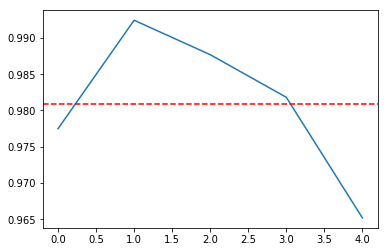

In [82]:
plt.plot(lr_scores)
plt.axhline(lr_mean_score, color='r', linestyle='--') # plot mean line 
plt.show()

#### Fit one model

In [83]:
lr = LogisticRegression(penalty = 'l2', 
                        C = 1, 
                        class_weight = 'balanced', 
                        solver = 'sag', 
                        max_iter = 100, 
                        random_state = 4896) 
lr.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=4896,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [84]:
y_pred = lr.predict(X_train)

#### Model Performance

In [85]:
def metrics(y, pred):
    print("Accuracy score: {:.2f}".format(accuracy_score(y, pred)))
    print("F1 score: {:.2f}".format(f1_score(y, pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y, pred)))

In [86]:
metrics(y_train, y_pred)

Accuracy score: 0.81
F1 score: 0.13
ROC AUC score: 0.80


In [87]:
def confusion_metrics(y, pred):
    cm = confusion_matrix(y, pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])
    print(" ")
    print("Other Metrics:")
    print(" ")
    print("Precision %.2f" % (cm[1][1] / (cm[1][1] + cm[0][1])))
    print("Recall / True Positive Rate %.2f" % (cm[1][1] / (cm[1][1] + cm[1][0])))   
    print("True Negative Rate: %.2f" % (cm[0][0] / (cm[0][0] + cm[0][1])))   

In [88]:
confusion_metrics(y_train, y_pred)

True Negatives: 4298
False Negatives: 22
True Positives: 79
False Positives: 1021
 
Other Metrics:
 
Precision 0.07
Recall / True Positive Rate 0.78
True Negative Rate: 0.81


#### Look at the Important Features

In [89]:
def plot_top_k_feature_importances(coefs, k):    
    # sort 
    args = abs(coefs).argsort()[::-1][:k]    
    # get coefs 
    top_k_coefs = coefs[args]    
    # get column names
    colnames = list(X_train.columns.values[args])
    # plot 
    plt.barh(range(k), top_k_coefs, align='center') 
    plt.yticks(np.arange(k), colnames) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, k)
    plt.show()

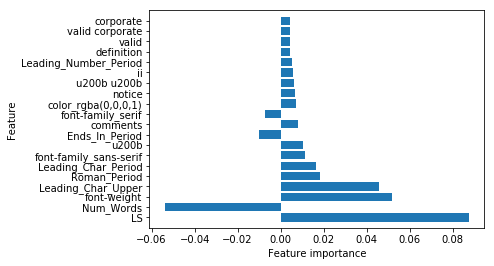

In [90]:
plot_top_k_feature_importances(lr.coef_[0], 20)

#### 1.2: L1 Penalty

In [91]:
lr = LogisticRegression(penalty = 'l1', 
                        C = 1, 
                        class_weight = 'balanced', 
                        # solver = 'sag', 
                        max_iter = 100, 
                        random_state = 4896) 
lr.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=4896,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [92]:
y_pred = lr.predict(X_train)

In [93]:
metrics(y_train, y_pred)

Accuracy score: 0.99
F1 score: 0.74
ROC AUC score: 0.99


In [94]:
confusion_metrics(y_train, y_pred)

True Negatives: 5248
False Negatives: 0
True Positives: 101
False Positives: 71
 
Other Metrics:
 
Precision 0.59
Recall / True Positive Rate 1.00
True Negative Rate: 0.99


#### Look at the Important Features

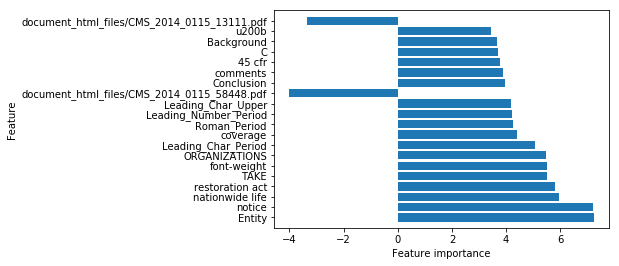

In [95]:
plot_top_k_feature_importances(lr.coef_[0], 20)

### 3. Random Forest

In [96]:
rf = RandomForestClassifier(class_weight = 'balanced') 
rf.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [97]:
y_pred = rf.predict(X_train)

#### Model Performance

In [98]:
metrics(y_train, y_pred)

Accuracy score: 1.00
F1 score: 0.98
ROC AUC score: 0.98


In [99]:
confusion_metrics(y_train, y_pred)

True Negatives: 5319
False Negatives: 4
True Positives: 97
False Positives: 0
 
Other Metrics:
 
Precision 1.00
Recall / True Positive Rate 0.96
True Negative Rate: 1.00


#### Look at the Important Features

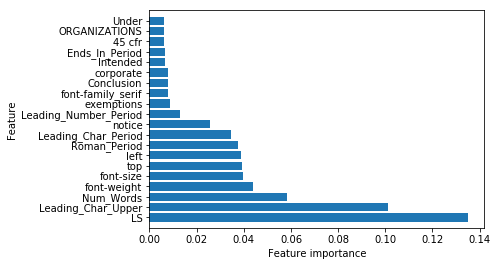

In [100]:
plot_top_k_feature_importances(rf.feature_importances_, 20)

### 5. Boosting: Adaboost

In [101]:
ab = AdaBoostClassifier() 
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [102]:
y_pred = ab.predict(X_train)

#### Model Performance

In [103]:
metrics(y_train, y_pred)

Accuracy score: 0.99
F1 score: 0.82
ROC AUC score: 0.87


In [104]:
confusion_metrics(y_train, y_pred)

True Negatives: 5313
False Negatives: 27
True Positives: 74
False Positives: 6
 
Other Metrics:
 
Precision 0.93
Recall / True Positive Rate 0.73
True Negative Rate: 1.00


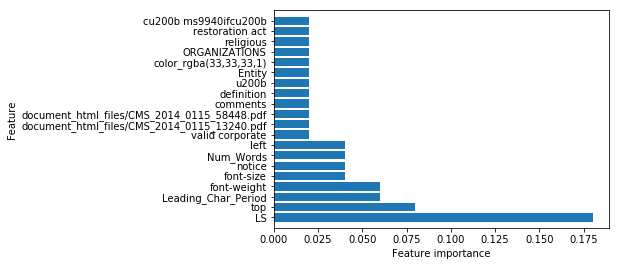

In [105]:
plot_top_k_feature_importances(ab.feature_importances_, 20)

### 5. Boosting: Gradient Boosting

In [106]:
gb = GradientBoostingClassifier() 
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [107]:
y_pred = gb.predict(X_train)

In [108]:
metrics(y_train, y_pred)

Accuracy score: 1.00
F1 score: 0.95
ROC AUC score: 0.96


In [109]:
confusion_metrics(y_train, y_pred)

True Negatives: 5317
False Negatives: 8
True Positives: 93
False Positives: 2
 
Other Metrics:
 
Precision 0.98
Recall / True Positive Rate 0.92
True Negative Rate: 1.00


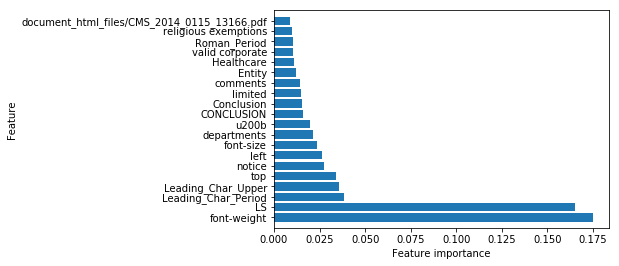

In [110]:
plot_top_k_feature_importances(gb.feature_importances_, 20)

### 6. XGBoost

#### Preprocessing for XGBoost
  - dtypes that XGBoost can take are int, float and bool.
  - We encode all categorical variables, accordingly.
  - This encoding doesn't have to be one-hot encoding.

In [101]:
X_train_cat = X_train_cat.drop(['text', 'document', 'color', 'First_Word', 'first_5_words', 'Last_Word'], axis=1)
X_test_cat = X_test_cat.drop(['text', 'document', 'color', 'First_Word', 'first_5_words', 'Last_Word'], axis=1)

In [102]:
X_train_cat.sample(3)

,index,font-family,first_3_words,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
5240,316,serif,with the mandate,1,0,0,0,0,0,0,0
895,5617,sans-serif,Using the Courts,0,1,0,0,0,0,0,0
3161,1563,serif,does not yield,2,0,0,0,0,0,0,0


In [103]:
X_test_cat.sample(3)

,index,font-family,first_3_words,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
1503,3481,sans-serif,Additionally HHS should,1,1,2,0,0,0,0,0
2241,2882,serif,satisfy four requirements,1,0,0,0,0,0,0,0
1326,40988,sans-serif,unintendedu200b u200bpregnancyu200b u200brateu...,1,0,0,0,0,0,0,0


In [104]:
encodee_cols = X_train_cat.select_dtypes(exclude=['int','float','bool']).columns
encodee_cols

Index(['font-family', 'first_3_words'], dtype='object')

In [105]:
# Additional preprocessing for XGBoost.
lb_train_encoder_list = []
lb_test_encoder_list = []
encodee_cols = X_train_cat.select_dtypes(exclude=['int','float','bool']).columns
X_train_encoded = pd.concat([X_train_num, X_train_cat], axis = 1)
X_test_encoded = pd.concat([X_test_num, X_test_cat], axis = 1)

# Encode categorical variables and add them into the dataset with a suffiix, '_encoded'
for i, c in enumerate(encodee_cols) :
    lb_train_encoder_list.append(preprocessing.LabelEncoder())
    lb_train_encoder_list[i].fit(X_train_cat[c])
    lb_test_encoder_list.append(preprocessing.LabelEncoder())
    lb_test_encoder_list[i].fit(X_test_cat[c])
    X_train_encoded = pd.concat([X_train_encoded,
                                 pd.Series(lb_train_encoder_list[i].transform(X_train_cat[c]), name=c+'_encoded')],
                                axis=1)
    X_test_encoded = pd.concat([X_test_encoded,
                                 pd.Series(lb_test_encoder_list[i].transform(X_test_cat[c]), name=c+'_encoded')],
                                axis=1)

# Drop the original, non-encoded, categorical variables.
X_train_encoded.drop(list(encodee_cols), axis=1, inplace=True)
X_test_encoded.drop(list(encodee_cols), axis=1, inplace=True)

Drop 'top' because 'LS' is derived from 'top', and seems to be more predictive.
Drop 'left' because different identifications in documents may confuse learning.

In [106]:
X_train_encoded.drop(['top', 'left'], axis=1, inplace=True)
X_test_encoded.drop(['top', 'left'], axis=1, inplace=True)

In [107]:
X_train_encoded.sample(5)

,index,font-size,Num_Words,LS,font-weight,font-style,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,...,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,font-family_encoded,first_3_words_encoded
285,41473,11,13.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,2113
1209,510,33,16.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,1590
1997,40631,9,17.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,1,0,0,0,0,0,0,0,2429
2008,2335,10,15.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,4157
944,4755,6,16.0,65.0,0.0,0.0,0.0,1.0,1.0,0.0,...,5,10,0,0,0,0,0,0,0,214


In [108]:
X_test_encoded.sample(5)

,index,font-size,Num_Words,LS,font-weight,font-style,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,...,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,font-family_encoded,first_3_words_encoded
239,41840,11,14.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1087
522,5089,8,1.0,16.0,1.0,0.0,0.0,1.0,0.0,1.0,...,2,0,0,0,0,0,0,0,0,1428
92,5158,10,17.0,23.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1,1,0,0,0,0,0,0,0,716
361,41669,11,13.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,1104
725,2903,12,5.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0,0,0,0,0,0,0,1,84


In [109]:
X_train_encoded.reset_index(inplace = True)
X_test_encoded.reset_index(inplace = True)

In [110]:
X_train_encoded.drop(['level_0', 'index'], axis=1, inplace=True)
X_test_encoded.drop(['level_0', 'index'], axis=1, inplace=True)

In [111]:
X_train_encoded.shape, X_test_encoded.shape

((5420, 21), (2323, 21))

In [112]:
# to prevent XGBoost from being died
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Running a model with cross-validation applied

In [113]:
# A main reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def xgboost_fit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        # get_xgb_params() is one of sklearn wrappers of xgboost package.
        # It returns parameters in actual xgboost format (not sklearn wrapper's)
        # We use this because the cv function requires parameters in that format.
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                    metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print("The best value of n_estimators is {:d}.".format(cvresult.shape[0]))
        print("Will use and set this value as the parameter, accordingly.")
        alg.set_params(n_estimators=cvresult.shape[0])
        
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], y_train)

    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprb = alg.predict_proba(dtrain[predictors])[:, 1]
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## 6.1 Case 1: scale_pos_weight = 1

### Step 1: Fix a learning rate as 0.1 for now, and set parameters without tuned. It will be tuned later.
  - I removed the index column, which happens to have the highest feature importance.
  - I am suspicious of *top* being one of the highest feature importance, but chose to leave it there because I don't know for sure what is going on behind the scene yet.
  
#### Tuning information and codes :
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

The best value of n_estimators is 60.
Will use and set this value as the parameter, accordingly.


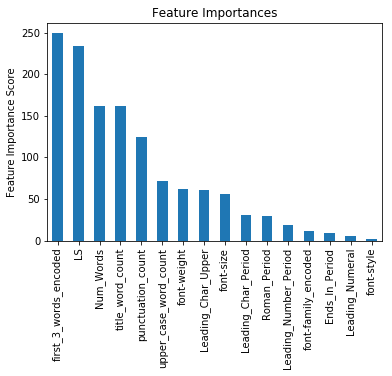

In [135]:
predictors = [x for x in X_train_encoded.columns]

xgb1 = xgb.XGBClassifier(
        # Used to control over-fitting as higher depth will allow model
        # to learn relations very specific to a particular sample.
        # Should be tuned using CV.
        # Typical values: 3-10
        max_depth=5,

        # Analogous to learning rate in GBM
        # Makes the model more robust by shrinking the weights on each step
        # Typical final values to be used: 0.01-0.2
        # default=0.3
        #eta=0.05,

        # Defines the minimum sum of weights of all observations required in a child.
        # This is similar to min_child_leaf in GBM but not exactly.
        # Used to control over-fitting. Higher values prevent a model from
        # learning relations which might be highly specific to the particular
        # sample selected for a tree.
        # Too high values can lead to under-fitting hence,
        # it should be tuned using CV.
        # default=1
        min_child_weight=1,

        learning_rate=0.1,
        n_estimators=1000,

        # one of binary:logistic, multi:softmax, multi:softprob
        objective='binary:logistic',

        # usually misunderstood parameter, it acts as a regularization parameter.
        # either 0, 1 or 5. default=0
        gamma=0,

        # Lower values make the algorithm more conservative
        # and prevents overfitting but too small values might lead to under-fitting.
        # typically 0.5-1
        subsample=1,

        # number of columns used by each tree.
        # In order to avoid some columns to take too much credit
        # for the prediction (think of it like in recommender systems
        # when you recommend the most purchased products and
        # forget about the long tail), take out a good proportion of columns.
        # Values from 0.3 to 0.8 if you have many columns
        # (especially if you did one-hot encoding),
        # or 0.8 to 1 if you only have a few columns.
        colsample_bytree=0.8,

        # Denotes the subsample ratio of columns for each split, in each level.
        # I don’t use this often because subsample and colsample_bytree
        # will do the job for you. but you can explore further if you feel so.
        # default=1
        colsample_bylevel=1,

        # L1 regularization term on weight (analogous to Lasso regression)
        # Can be used in case of very high dimensionality so that
        # the algorithm runs faster when implemented
        # default=0
        reg_alpha=0,

        # L2 regularization term on weights (analogous to Ridge regression)
        # This used to handle the regularization part of XGBoost.
        # Though many data scientists don’t use it often,
        # it should be explored to reduce overfitting.
        # default=1
        reg_lambda=0,

        # A value greater than 0 should be used in case of
        # high class imbalance as it helps in faster convergence.
        # default=1
        scale_pos_weight=1,
        seed=1)

xgboost_fit(xgb1, X_train_encoded, predictors)

In [116]:
# predictors = [x for x in X_train_encoded.columns]

# xgb1 = xgb.XGBClassifier(
#         # Used to control over-fitting as higher depth will allow model
#         # to learn relations very specific to a particular sample.
#         # Should be tuned using CV.
#         # Typical values: 3-10
#         max_depth=10,

#         # Analogous to learning rate in GBM
#         # Makes the model more robust by shrinking the weights on each step
#         # Typical final values to be used: 0.01-0.2
#         # default=0.3
#         #eta=0.05,

#         # Defines the minimum sum of weights of all observations required in a child.
#         # This is similar to min_child_leaf in GBM but not exactly.
#         # Used to control over-fitting. Higher values prevent a model from
#         # learning relations which might be highly specific to the particular
#         # sample selected for a tree.
#         # Too high values can lead to under-fitting hence,
#         # it should be tuned using CV.
#         # default=1
#         min_child_weight=1,

#         learning_rate=0.1,
#         n_estimators=60,

#         # one of binary:logistic, multi:softmax, multi:softprob
#         objective='binary:logistic',

#         # usually misunderstood parameter, it acts as a regularization parameter.
#         # either 0, 1 or 5. default=0
#         gamma=0.46,

#         # Lower values make the algorithm more conservative
#         # and prevents overfitting but too small values might lead to under-fitting.
#         # typically 0.5-1
#         subsample=0.7,

#         # number of columns used by each tree.
#         # In order to avoid some columns to take too much credit
#         # for the prediction (think of it like in recommender systems
#         # when you recommend the most purchased products and
#         # forget about the long tail), take out a good proportion of columns.
#         # Values from 0.3 to 0.8 if you have many columns
#         # (especially if you did one-hot encoding),
#         # or 0.8 to 1 if you only have a few columns.
#         colsample_bytree=0.95,

#         # Denotes the subsample ratio of columns for each split, in each level.
#         # I don’t use this often because subsample and colsample_bytree
#         # will do the job for you. but you can explore further if you feel so.
#         # default=1
#         colsample_bylevel=1,

#         # L1 regularization term on weight (analogous to Lasso regression)
#         # Can be used in case of very high dimensionality so that
#         # the algorithm runs faster when implemented
#         # default=0
#         reg_alpha=0.03,

#         # L2 regularization term on weights (analogous to Ridge regression)
#         # This used to handle the regularization part of XGBoost.
#         # Though many data scientists don’t use it often,
#         # it should be explored to reduce overfitting.
#         # default=1
#         reg_lambda=0.0055,

#         # A value greater than 0 should be used in case of
#         # high class imbalance as it helps in faster convergence.
#         # default=1
#         scale_pos_weight=1,
#         seed=1)

# xgboost_fit(xgb1, X_train_encoded, predictors)

$Tuned$
- *n_estimators* = 60 (The number of trees)

In [136]:
y_pred = np.round(xgb1.predict(X_test_encoded))
y_pro = xgb1.predict_proba(X_test_encoded)[:, 1]

In [137]:
y_test.shape, y_pred.shape

((2323,), (2323,))

In [138]:
def metrics(y_test, y_pred):
    print("Score on a test set")
    print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

y_test.shape, y_pred.shape

metrics(y_test, y_pred)

def confusion_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])
    print("Precision: {:.2f}".format(cm[1][1]/float(cm[1][1]+cm[0][1])))
    print("Recall: {:.2f}".format(cm[1][1]/float(cm[1][1]+cm[1][0])))

confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.70
ROC AUC score: 0.81
True Negatives: 2277
False Negatives: 15
True Positives: 25
False Positives: 6
Precision: 0.81
Recall: 0.62


### Step 2: Tune *max_depth* and *min_child_weight*

In [126]:
param_test1 = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2)
}

# n_estimators is set to be 175 because we found it as the best in step 1.
gsearch1 = GridSearchCV(estimator = XGBClassifier(
                                        max_depth=5,
                                        min_child_weight=1,
                                        learning_rate=0.1,
                                        n_estimators=60,
                                        objective='binary:logistic',
                                        gamma=0,
                                        subsample=1,
                                        colsample_bytree=0.8,
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test1, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch1.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [54]:
results = pd.DataFrame(gsearch1.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch1.best_params_)
print("Its (best) score is", gsearch1.best_score_)

0     {'max_depth': 3, 'min_child_weight': 1}
1     {'max_depth': 3, 'min_child_weight': 3}
2     {'max_depth': 3, 'min_child_weight': 5}
3     {'max_depth': 5, 'min_child_weight': 1}
4     {'max_depth': 5, 'min_child_weight': 3}
5     {'max_depth': 5, 'min_child_weight': 5}
6     {'max_depth': 7, 'min_child_weight': 1}
7     {'max_depth': 7, 'min_child_weight': 3}
8     {'max_depth': 7, 'min_child_weight': 5}
9     {'max_depth': 9, 'min_child_weight': 1}
10    {'max_depth': 9, 'min_child_weight': 3}
11    {'max_depth': 9, 'min_child_weight': 5}
Name: params, dtype: object 0     0.624045
1     0.607033
2     0.548871
3     0.719325
4     0.702523
5     0.636333
6     0.706490
7     0.711369
8     0.643821
9     0.724074
10    0.706246
11    0.641261
Name: mean_test_score, dtype: float64
The best parameters are {'max_depth': 9, 'min_child_weight': 1}
Its (best) score is 0.7240740740740741


$Tuned$ (not confirmed yet)
- n_estimators = 60
- *max_depth* = 9
- *min_child_weight* = 1

#### We did the gridsearch with an interval of 2 for *Max_depth*. Let's do it with a unit interval to tune a little more.

In [127]:
param_test2 = {
    'max_depth': [8,9,10,11,12]
}

# n_estimators is set to be 175 because we found it as the best in step 1.
gsearch2 = GridSearchCV(estimator = XGBClassifier(
                                        max_depth=5,
                                        min_child_weight=1,
                                        learning_rate=0.1,
                                        n_estimators=60,
                                        objective='binary:logistic',
                                        gamma=0,
                                        subsample=1,
                                        colsample_bytree=0.8,
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test2, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch2.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [8, 9, 10, 11, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [128]:
results = pd.DataFrame(gsearch2.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch2.best_params_)
print("Its (best) score is", gsearch2.best_score_)

0     {'max_depth': 8}
1     {'max_depth': 9}
2    {'max_depth': 10}
3    {'max_depth': 11}
4    {'max_depth': 12}
Name: params, dtype: object 0    0.734957
1    0.747611
2    0.753266
3    0.737579
4    0.743385
Name: mean_test_score, dtype: float64
The best parameters are {'max_depth': 10}
Its (best) score is 0.7532657038556074


$Tuned$ (confirmed)
- *max_depth* = 10
- *min_child_weight* = 1

### Step 3: Tune gamma

In [129]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=60,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0,
                                        objective='binary:logistic',
                                        subsample=1,
                                        colsample_bytree=0.8,
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test3, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch3.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [130]:
results = pd.DataFrame(gsearch3.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch3.best_params_)
print("Its (best) score is", gsearch3.best_score_)

0    {'gamma': 0.0}
1    {'gamma': 0.1}
2    {'gamma': 0.2}
3    {'gamma': 0.3}
4    {'gamma': 0.4}
Name: params, dtype: object 0    0.753266
1    0.756714
2    0.752520
3    0.750513
4    0.760415
Name: mean_test_score, dtype: float64
The best parameters are {'gamma': 0.4}
Its (best) score is 0.7604150620453574


$Tuned$ (so far)
- n_of_estimators = 60
- max_depth = 10
- min_child_weight = 1
- *gamma* = 0.4

In [131]:
param_test3b = {
    'gamma':[i/100.0 for i in range(30,50, 2)]
}

# Tuned parameters under learning rate = 0.1 so far:
#   n_estimators = 110
#   max_depth = 7
#   min_child_weight = 1
gsearch3b = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=60,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0,
                                        objective='binary:logistic',
                                        subsample=1,
                                        colsample_bytree=0.8,
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test3b, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch3b.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [132]:
results = pd.DataFrame(gsearch3b.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch3b.best_params_)
print("Its (best) score is", gsearch3b.best_score_)

0     {'gamma': 0.3}
1    {'gamma': 0.32}
2    {'gamma': 0.34}
3    {'gamma': 0.36}
4    {'gamma': 0.38}
5     {'gamma': 0.4}
6    {'gamma': 0.42}
7    {'gamma': 0.44}
8    {'gamma': 0.46}
9    {'gamma': 0.48}
Name: params, dtype: object 0    0.750513
1    0.748862
2    0.756366
3    0.740256
4    0.745216
5    0.760415
6    0.754472
7    0.753872
8    0.766025
9    0.752276
Name: mean_test_score, dtype: float64
The best parameters are {'gamma': 0.46}
Its (best) score is 0.7660248181429183


$Tuned$ (so far)
- n_of_estimators = 60
- max_depth = 10
- min_child_weight = 1
- *gamma* = 0.46

#### Using tuned parameters, let's run the model again and see how much it improves.

The best value of n_estimators is 60.
Will use and set this value as the parameter, accordingly.


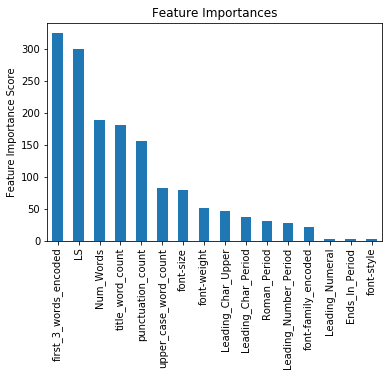

In [133]:
xgb2 = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=60,
        max_depth=10,
        min_child_weight=1,
        gamma=0.46,
        subsample=1,
        colsample_bytree=0.8,
        objective='binary:logistic',
        colsample_bylevel=1,
        reg_alpha=0,
        reg_lambda=0,
        scale_pos_weight=1,
        seed=1)

xgboost_fit(xgb2, X_train_encoded, predictors)

In [134]:
y_pred = np.round(xgb2.predict(X_test_encoded))
y_pro = xgb2.predict_proba(X_test_encoded)[:, 1]

In [135]:
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.66
ROC AUC score: 0.79
True Negatives: 2276
False Negatives: 17
True Positives: 23
False Positives: 7
Precision: 0.77
Recall: 0.57


### Step 4: Tune subsample and colsample_bytree

In [137]:
param_test4 = {
    'subsample' : [i/10.0 for i in range(6,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=60,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0.46,
                                        subsample=1,
                                        colsample_bytree=0.8,
                                        objective='binary:logistic',
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test4, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch4.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.46, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=60, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=1, silent=True, subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [138]:
results = pd.DataFrame(gsearch4.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch4.best_params_)
print("Its (best) score is", gsearch4.best_score_)

0     {'colsample_bytree': 0.6, 'subsample': 0.6}
1     {'colsample_bytree': 0.6, 'subsample': 0.7}
2     {'colsample_bytree': 0.6, 'subsample': 0.8}
3     {'colsample_bytree': 0.6, 'subsample': 0.9}
4     {'colsample_bytree': 0.7, 'subsample': 0.6}
5     {'colsample_bytree': 0.7, 'subsample': 0.7}
6     {'colsample_bytree': 0.7, 'subsample': 0.8}
7     {'colsample_bytree': 0.7, 'subsample': 0.9}
8     {'colsample_bytree': 0.8, 'subsample': 0.6}
9     {'colsample_bytree': 0.8, 'subsample': 0.7}
10    {'colsample_bytree': 0.8, 'subsample': 0.8}
11    {'colsample_bytree': 0.8, 'subsample': 0.9}
12    {'colsample_bytree': 0.9, 'subsample': 0.6}
13    {'colsample_bytree': 0.9, 'subsample': 0.7}
14    {'colsample_bytree': 0.9, 'subsample': 0.8}
15    {'colsample_bytree': 0.9, 'subsample': 0.9}
Name: params, dtype: object 0     0.724982
1     0.732811
2     0.719994
3     0.741709
4     0.727828
5     0.746376
6     0.736582
7     0.746635
8     0.730075
9     0.723827
10    0.727953
11    0

We have 0.7 for *colsample_bytree* and 0.9 for *subsample*, but let's do this again with a finer interval of 0.05

In [139]:
param_test5 = {
    'subsample' : [i/100.0 for i in range(65,80,5)],
    'colsample_bytree': [i/100.0 for i in range(85,100,5)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=60,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0.46,
                                        subsample=0.9,
                                        colsample_bytree=0.9,
                                        objective='binary:logistic',
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test5, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch5.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.46, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=60, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.9),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.65, 0.7, 0.75], 'colsample_bytree': [0.85, 0.9, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [140]:
results = pd.DataFrame(gsearch5.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch5.best_params_)
print("Its (best) score is", gsearch5.best_score_)

0    {'colsample_bytree': 0.85, 'subsample': 0.65}
1     {'colsample_bytree': 0.85, 'subsample': 0.7}
2    {'colsample_bytree': 0.85, 'subsample': 0.75}
3     {'colsample_bytree': 0.9, 'subsample': 0.65}
4      {'colsample_bytree': 0.9, 'subsample': 0.7}
5     {'colsample_bytree': 0.9, 'subsample': 0.75}
6    {'colsample_bytree': 0.95, 'subsample': 0.65}
7     {'colsample_bytree': 0.95, 'subsample': 0.7}
8    {'colsample_bytree': 0.95, 'subsample': 0.75}
Name: params, dtype: object 0    0.745869
1    0.740561
2    0.727580
3    0.749262
4    0.740592
5    0.731053
6    0.757902
7    0.759221
8    0.737881
Name: mean_test_score, dtype: float64
The best parameters are {'colsample_bytree': 0.95, 'subsample': 0.7}
Its (best) score is 0.7592207792207792


$Tuned$ (so far)
- n_of_estimators = 60
- max_depth = 10
- min_child_weight = 1
- gamma = 0.46
- *colsample_by_tree* = 0.95
- *subsample* = 0.7

### Step 5: Tune regularization parameters

In [141]:
param_test6 = {
    'reg_alpha':[0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100],
    'reg_lambda':[0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=60,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0.04,
                                        colsample_bytree=0.95,
                                        subsample=0.7,
                                        objective='binary:logistic',
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test6, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch6.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, gamma=0.04, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=60, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'reg_lambda': [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [142]:
results = pd.DataFrame(gsearch6.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch6.best_params_)
print("Its (best) score is", gsearch6.best_score_)

0               {'reg_alpha': 0, 'reg_lambda': 0}
1           {'reg_alpha': 0, 'reg_lambda': 1e-05}
2          {'reg_alpha': 0, 'reg_lambda': 0.0001}
3           {'reg_alpha': 0, 'reg_lambda': 0.001}
4            {'reg_alpha': 0, 'reg_lambda': 0.01}
5             {'reg_alpha': 0, 'reg_lambda': 0.1}
6               {'reg_alpha': 0, 'reg_lambda': 1}
7              {'reg_alpha': 0, 'reg_lambda': 10}
8             {'reg_alpha': 0, 'reg_lambda': 100}
9           {'reg_alpha': 1e-05, 'reg_lambda': 0}
10      {'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
11     {'reg_alpha': 1e-05, 'reg_lambda': 0.0001}
12      {'reg_alpha': 1e-05, 'reg_lambda': 0.001}
13       {'reg_alpha': 1e-05, 'reg_lambda': 0.01}
14        {'reg_alpha': 1e-05, 'reg_lambda': 0.1}
15          {'reg_alpha': 1e-05, 'reg_lambda': 1}
16         {'reg_alpha': 1e-05, 'reg_lambda': 10}
17        {'reg_alpha': 1e-05, 'reg_lambda': 100}
18         {'reg_alpha': 0.0001, 'reg_lambda': 0}
19     {'reg_alpha': 0.0001, 'reg_lambda': 1e-05}


*reg_alpha*: 0.01, *reg_lambda*: 0.001. Let's tune this further with a fine interval.

In [145]:
param_test7 = {
    'reg_alpha':[i/1000.0 for i in range(5, 100, 5) ],
    'reg_lambda':[i/10000.0 for i in range(5, 100, 5)]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(
                                        learning_rate=0.1,
                                        n_estimators=60,
                                        max_depth=10,
                                        min_child_weight=1,
                                        gamma=0.46,
                                        colsample_bytree=0.95,
                                        subsample=0.70,
                                        objective='binary:logistic',
                                        colsample_bylevel=1,
                                        reg_alpha=0,
                                        reg_lambda=0,
                                        scale_pos_weight=1,
                                        seed=1),
                        param_grid = param_test7, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch7.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.95, gamma=0.46, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=60, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.7),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095], 'reg_lambda': [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008, 0.0085, 0.009, 0.0095]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [146]:
results = pd.DataFrame(gsearch7.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch7.best_params_)
print("Its (best) score is", gsearch7.best_score_)

0      {'reg_alpha': 0.005, 'reg_lambda': 0.0005}
1       {'reg_alpha': 0.005, 'reg_lambda': 0.001}
2      {'reg_alpha': 0.005, 'reg_lambda': 0.0015}
3       {'reg_alpha': 0.005, 'reg_lambda': 0.002}
4      {'reg_alpha': 0.005, 'reg_lambda': 0.0025}
5       {'reg_alpha': 0.005, 'reg_lambda': 0.003}
6      {'reg_alpha': 0.005, 'reg_lambda': 0.0035}
7       {'reg_alpha': 0.005, 'reg_lambda': 0.004}
8      {'reg_alpha': 0.005, 'reg_lambda': 0.0045}
9       {'reg_alpha': 0.005, 'reg_lambda': 0.005}
10     {'reg_alpha': 0.005, 'reg_lambda': 0.0055}
11      {'reg_alpha': 0.005, 'reg_lambda': 0.006}
12     {'reg_alpha': 0.005, 'reg_lambda': 0.0065}
13      {'reg_alpha': 0.005, 'reg_lambda': 0.007}
14     {'reg_alpha': 0.005, 'reg_lambda': 0.0075}
15      {'reg_alpha': 0.005, 'reg_lambda': 0.008}
16     {'reg_alpha': 0.005, 'reg_lambda': 0.0085}
17      {'reg_alpha': 0.005, 'reg_lambda': 0.009}
18     {'reg_alpha': 0.005, 'reg_lambda': 0.0095}
19      {'reg_alpha': 0.01, 'reg_lambda': 0.0005}


$Tuned$ (so far)
- n_of_estimators = 60
- max_depth = 10
- min_child_weight = 1
- gamma = 0.46
- colsample_by_tree = 0.95
- subsample = 0.7
- *reg_alpha* = 0.03
- *reg_lambda* = 0.0055

#### Try to run a model with all the parameters we've tuned so far for a learning rate of 0.1.

The best value of n_estimators is 60.
Will use and set this value as the parameter, accordingly.


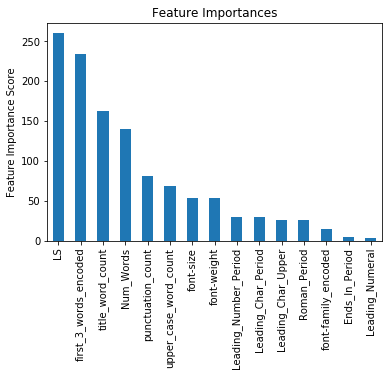

In [147]:
xgb3 = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=60,
        max_depth=10,
        min_child_weight=1,
        gamma=0.46,
        colsample_bytree=0.95,
        subsample=0.7,
        objective='binary:logistic',
        colsample_bylevel=1,
        reg_alpha=0.03,
        reg_lambda=0.0055,
        scale_pos_weight=1,
        seed=1)

xgboost_fit(xgb3, X_train_encoded, predictors)

In [148]:
y_pred = np.round(xgb3.predict(X_test_encoded))
y_pro = xgb3.predict_proba(X_test_encoded)[:, 1]
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.67
ROC AUC score: 0.81
True Negatives: 2273
False Negatives: 15
True Positives: 25
False Positives: 10
Precision: 0.71
Recall: 0.62


### Step 6: Reduce a learning rate and add more trees.

The best value of n_estimators is 194.
Will use and set this value as the parameter, accordingly.


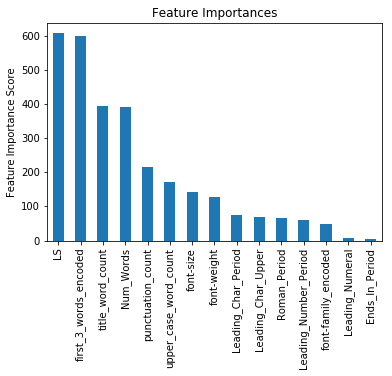

In [178]:
xgb4 = xgb.XGBClassifier(
        learning_rate=0.05,
        n_estimators=2000,
        max_depth=10,
        min_child_weight=1,
        gamma=0.46,
        colsample_bytree=0.95,
        subsample=0.7,
        objective='binary:logistic',
        colsample_bylevel=1,
        reg_alpha=0.03,
        reg_lambda=0.0055,
        scale_pos_weight=1,
        seed=1)

xgboost_fit(xgb4, X_train_encoded, predictors)

In [179]:
y_pred = np.round(xgb4.predict(X_test_encoded))
y_pro = xgb4.predict_proba(X_test_encoded)[:, 1]
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.65
ROC AUC score: 0.79
True Negatives: 2275
False Negatives: 17
True Positives: 23
False Positives: 8
Precision: 0.74
Recall: 0.57


$Tuned$ (for a learning rate of 0.05)
- n_of_estimators = 194
- max_depth = 10
- min_child_weight = 1
- gamma = 0.04
- colsample_by_tree = 0.9
- subsample = 0.75
- *reg_alpha* = 1.2e-05
- *reg_lambda* = 0.00014

The best value of n_estimators is 194.
Will use and set this value as the parameter, accordingly.


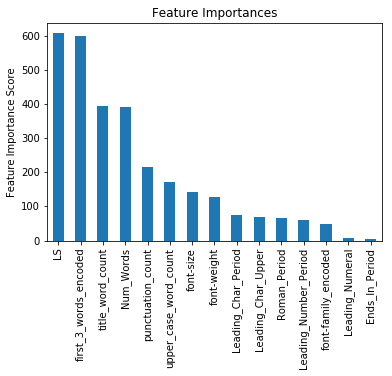

In [180]:
xgb5 = xgb.XGBClassifier(
        learning_rate=0.05,
        n_estimators=194,
        max_depth=10,
        min_child_weight=1,
        gamma=0.46,
        colsample_bytree=0.95,
        subsample=0.7,
        objective='binary:logistic',
        colsample_bylevel=1,
        reg_alpha=0.03,
        reg_lambda=0.0055,
        scale_pos_weight=1,
        seed=1)

xgboost_fit(xgb5, X_train_encoded, predictors)

In [181]:
y_pred = np.round(xgb5.predict(X_test_encoded))
y_pro = xgb5.predict_proba(X_test_encoded)[:, 1]
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.65
ROC AUC score: 0.79
True Negatives: 2275
False Negatives: 17
True Positives: 23
False Positives: 8
Precision: 0.74
Recall: 0.57


## 6.2 Set *scale_pos_weight* to be sum(negative instances)/sum(positive instances)

In [114]:
pos_wt = int(np.sum(y_train==0)/np.sum(y_train==1))
pos_wt

46

### Step 1: Fix a learning rate as 0.1 for now, and set parameters without tuned. It will be tuned later.
  - I removed the index column, which happens to have the highest feature importance.
  - I am suspicious of *top* being one of the highest feature importance, but chose to leave it there because I don't know for sure what is going on behind the scene yet.
  
#### Tuning information and codes :
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

In [115]:
# Used to control over-fitting as higher depth will allow model
# to learn relations very specific to a particular sample.
# Should be tuned using CV.
# Typical values: 3-10
max_depth=5

# Analogous to learning rate in GBM
# Makes the model more robust by shrinking the weights on each step
# Typical final values to be used: 0.01-0.2
# default=0.3
#eta=0.05,

# Defines the minimum sum of weights of all observations required in a child.
# This is similar to min_child_leaf in GBM but not exactly.
# Used to control over-fitting. Higher values prevent a model from
# learning relations which might be highly specific to the particular
# sample selected for a tree.
# Too high values can lead to under-fitting hence,
# it should be tuned using CV.
# default=1
min_child_weight=1

learning_rate=0.1
n_estimators=1000

# one of binary:logistic, multi:softmax, multi:softprob
objective='binary:logistic'

# usually misunderstood parameter, it acts as a regularization parameter.
# either 0, 1 or 5. default=0
gamma=0

# Lower values make the algorithm more conservative
# and prevents overfitting but too small values might lead to under-fitting.
# typically 0.5-1
subsample=1

# number of columns used by each tree.
# In order to avoid some columns to take too much credit
# for the prediction (think of it like in recommender systems
# when you recommend the most purchased products and
# forget about the long tail), take out a good proportion of columns.
# Values from 0.3 to 0.8 if you have many columns
# (especially if you did one-hot encoding),
# or 0.8 to 1 if you only have a few columns.
colsample_bytree=0.8

# Denotes the subsample ratio of columns for each split, in each level.
# I don’t use this often because subsample and colsample_bytree
# will do the job for you. but you can explore further if you feel so.
# default=1
colsample_bylevel=1

# L1 regularization term on weight (analogous to Lasso regression)
# Can be used in case of very high dimensionality so that
# the algorithm runs faster when implemented
# default=0
reg_alpha=0

# L2 regularization term on weights (analogous to Ridge regression)
# This used to handle the regularization part of XGBoost.
# Though many data scientists don’t use it often,
# it should be explored to reduce overfitting.
# default=1
reg_lambda=0

# A value greater than 0 should be used in case of
# high class imbalance as it helps in faster convergence.
# default=1
scale_pos_weight=pos_wt
seed=1

The best value of n_estimators is 186.
Will use and set this value as the parameter, accordingly.


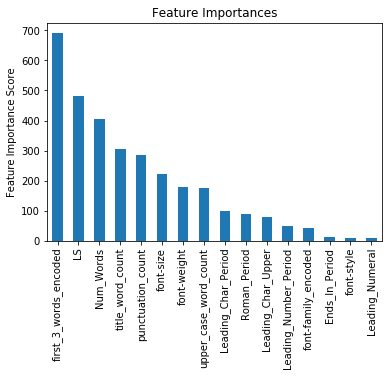

In [116]:
predictors = [x for x in X_train_encoded.columns]

xgb1 = xgb.XGBClassifier(
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        objective='binary:logistic',
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=pos_wt,
        seed=seed)

xgboost_fit(xgb1, X_train_encoded, predictors)

$Tuned$
- *n_estimators* = 186 (The number of trees)

In [117]:
n_estimators=186

In [118]:
y_pred = np.round(xgb1.predict(X_test_encoded))
y_pro = xgb1.predict_proba(X_test_encoded)[:, 1]

In [119]:
y_test.shape, y_pred.shape

((2323,), (2323,))

In [120]:
def metrics(y_test, y_pred):
    print("Score on a test set")
    print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

y_test.shape, y_pred.shape

metrics(y_test, y_pred)

def confusion_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])
    print("Precision: {:.2f}".format(cm[1][1]/float(cm[1][1]+cm[0][1])))
    print("Recall: {:.2f}".format(cm[1][1]/float(cm[1][1]+cm[1][0])))

confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.66
ROC AUC score: 0.87
True Negatives: 2262
False Negatives: 10
True Positives: 30
False Positives: 21
Precision: 0.59
Recall: 0.75


### Step 2: Tune *max_depth* and *min_child_weight*

In [121]:
param_test1 = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            objective='binary:logistic',
                            gamma=gamma,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            scale_pos_weight=pos_wt,
                            seed=seed),
                        param_grid = param_test1, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch1.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=186,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=46, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [122]:
results = pd.DataFrame(gsearch1.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch1.best_params_)
print("Its (best) score is", gsearch1.best_score_)

0     {'max_depth': 3, 'min_child_weight': 1}
1     {'max_depth': 3, 'min_child_weight': 3}
2     {'max_depth': 3, 'min_child_weight': 5}
3     {'max_depth': 5, 'min_child_weight': 1}
4     {'max_depth': 5, 'min_child_weight': 3}
5     {'max_depth': 5, 'min_child_weight': 5}
6     {'max_depth': 7, 'min_child_weight': 1}
7     {'max_depth': 7, 'min_child_weight': 3}
8     {'max_depth': 7, 'min_child_weight': 5}
9     {'max_depth': 9, 'min_child_weight': 1}
10    {'max_depth': 9, 'min_child_weight': 3}
11    {'max_depth': 9, 'min_child_weight': 5}
Name: params, dtype: object 0     0.721829
1     0.715800
2     0.718742
3     0.767764
4     0.772252
5     0.757852
6     0.772086
7     0.783627
8     0.756829
9     0.781716
10    0.760604
11    0.766398
Name: mean_test_score, dtype: float64
The best parameters are {'max_depth': 7, 'min_child_weight': 3}
Its (best) score is 0.783627293341579


$Tuned$ (not confirmed yet)
- n_estimators = 186
- *max_depth* = 7
- *min_child_weight* = 3

In [123]:
max_depth = 7
min_child_weight = 3 

#### We did the gridsearch with an interval of 2 for *Max_depth*. Let's do it with a unit interval to tune a little more.

In [124]:
param_test2 = {
    'max_depth': [6,7,8]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            objective='binary:logistic',
                            gamma=gamma,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            scale_pos_weight=pos_wt,
                            seed=seed),
                        param_grid = param_test2, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch2.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=3, missing=None, n_estimators=186,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=46, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [6, 7, 8]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=False, scoring='f1', verbose=0)

In [125]:
results = pd.DataFrame(gsearch2.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch2.best_params_)
print("Its (best) score is", gsearch2.best_score_)

0    {'max_depth': 6}
1    {'max_depth': 7}
2    {'max_depth': 8}
Name: params, dtype: object 0    0.788294
1    0.783627
2    0.776319
Name: mean_test_score, dtype: float64
The best parameters are {'max_depth': 6}
Its (best) score is 0.7882935301780287


$Tuned$
- *max_depth* = 6

In [126]:
max_depth = 6

In [127]:
param_test2b = {
    'min_child_weight': [2,3,4]
}

gsearch2b = GridSearchCV(estimator = XGBClassifier(
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            objective='binary:logistic',
                            gamma=gamma,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            scale_pos_weight=pos_wt,
                            seed=seed),
                        param_grid = param_test2b, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch2b.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=186,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=46, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [2, 3, 4]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=False, scoring='f1', verbose=0)

In [128]:
results = pd.DataFrame(gsearch2b.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch2b.best_params_)
print("Its (best) score is", gsearch2b.best_score_)

0    {'min_child_weight': 2}
1    {'min_child_weight': 3}
2    {'min_child_weight': 4}
Name: params, dtype: object 0    0.776061
1    0.788294
2    0.757990
Name: mean_test_score, dtype: float64
The best parameters are {'min_child_weight': 3}
Its (best) score is 0.7882935301780287


$Tuned$
- *min_child_weight* = 3

In [129]:
min_child_weight=3

### Step 3: Tune gamma

In [130]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            objective='binary:logistic',
                            gamma=gamma,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            scale_pos_weight=pos_wt,
                            seed=seed),
                        param_grid = param_test3, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch3.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=186,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=46, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [132]:
results = pd.DataFrame(gsearch3.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch3.best_params_)
print("Its (best) score is", gsearch3.best_score_)

0    {'gamma': 0.0}
1    {'gamma': 0.1}
2    {'gamma': 0.2}
3    {'gamma': 0.3}
4    {'gamma': 0.4}
Name: params, dtype: object 0    0.788294
1    0.782155
2    0.780483
3    0.773375
4    0.768739
Name: mean_test_score, dtype: float64
The best parameters are {'gamma': 0.0}
Its (best) score is 0.7882935301780287


In [133]:
gamma = 0

In [134]:
param_test3b = {
    'gamma':[i/100.0 for i in range(0,6)]
}

# Tuned parameters under learning rate = 0.1 so far:
#   n_estimators = 110
#   max_depth = 7
#   min_child_weight = 1
gsearch3b = GridSearchCV(estimator = XGBClassifier(
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            objective='binary:logistic',
                            gamma=gamma,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            scale_pos_weight=pos_wt,
                            seed=seed),
                        param_grid = param_test3b, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch3b.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=186,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=46, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [135]:
results = pd.DataFrame(gsearch3b.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch3b.best_params_)
print("Its (best) score is", gsearch3b.best_score_)

0     {'gamma': 0.0}
1    {'gamma': 0.01}
2    {'gamma': 0.02}
3    {'gamma': 0.03}
4    {'gamma': 0.04}
5    {'gamma': 0.05}
Name: params, dtype: object 0    0.788294
1    0.787759
2    0.793124
3    0.777010
4    0.779404
5    0.786312
Name: mean_test_score, dtype: float64
The best parameters are {'gamma': 0.02}
Its (best) score is 0.7931244480524249


gamma = 0.02

#### Using tuned parameters, let's run the model again and see how much it improves.

The best value of n_estimators is 121.
Will use and set this value as the parameter, accordingly.


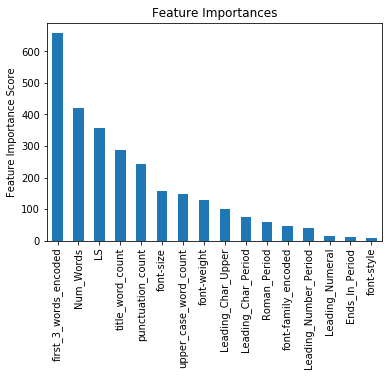

In [136]:
xgb2 = xgb.XGBClassifier(
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    objective='binary:logistic',
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    colsample_bylevel=colsample_bylevel,
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    scale_pos_weight=pos_wt,
    seed=seed)

xgboost_fit(xgb2, X_train_encoded, predictors)

In [137]:
y_pred = np.round(xgb2.predict(X_test_encoded))
y_pro = xgb2.predict_proba(X_test_encoded)[:, 1]

In [138]:
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.64
ROC AUC score: 0.86
True Negatives: 2261
False Negatives: 11
True Positives: 29
False Positives: 22
Precision: 0.57
Recall: 0.72


### Step 4: Tune subsample and colsample_bytree

In [139]:
param_test4 = {
    'subsample' : [i/10.0 for i in range(6,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            objective='binary:logistic',
                            gamma=gamma,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            scale_pos_weight=pos_wt,
                            seed=seed),
                        param_grid = param_test4, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch4.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=186,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=46, seed=1, silent=True,
       subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [140]:
results = pd.DataFrame(gsearch4.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch4.best_params_)
print("Its (best) score is", gsearch4.best_score_)

0     {'colsample_bytree': 0.6, 'subsample': 0.6}
1     {'colsample_bytree': 0.6, 'subsample': 0.7}
2     {'colsample_bytree': 0.6, 'subsample': 0.8}
3     {'colsample_bytree': 0.6, 'subsample': 0.9}
4     {'colsample_bytree': 0.7, 'subsample': 0.6}
5     {'colsample_bytree': 0.7, 'subsample': 0.7}
6     {'colsample_bytree': 0.7, 'subsample': 0.8}
7     {'colsample_bytree': 0.7, 'subsample': 0.9}
8     {'colsample_bytree': 0.8, 'subsample': 0.6}
9     {'colsample_bytree': 0.8, 'subsample': 0.7}
10    {'colsample_bytree': 0.8, 'subsample': 0.8}
11    {'colsample_bytree': 0.8, 'subsample': 0.9}
12    {'colsample_bytree': 0.9, 'subsample': 0.6}
13    {'colsample_bytree': 0.9, 'subsample': 0.7}
14    {'colsample_bytree': 0.9, 'subsample': 0.8}
15    {'colsample_bytree': 0.9, 'subsample': 0.9}
Name: params, dtype: object 0     0.733738
1     0.768524
2     0.756926
3     0.784900
4     0.743126
5     0.751946
6     0.766855
7     0.764048
8     0.735350
9     0.733509
10    0.761488
11    0

In [141]:
colsample_bytree = 0.6
subsample = 0.9

In [142]:
param_test5 = {
    'colsample_bytree': [i/100.0 for i in range(55,70,5)],
    'subsample' : [i/100.0 for i in range(85,100,5)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            objective='binary:logistic',
                            gamma=gamma,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            scale_pos_weight=pos_wt,
                            seed=seed),
                        param_grid = param_test5, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch5.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=186,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=46, seed=1, silent=True,
       subsample=0.9),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'colsample_bytree': [0.55, 0.6, 0.65], 'subsample': [0.85, 0.9, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [143]:
results = pd.DataFrame(gsearch5.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch5.best_params_)
print("Its (best) score is", gsearch5.best_score_)

0    {'colsample_bytree': 0.55, 'subsample': 0.85}
1     {'colsample_bytree': 0.55, 'subsample': 0.9}
2    {'colsample_bytree': 0.55, 'subsample': 0.95}
3     {'colsample_bytree': 0.6, 'subsample': 0.85}
4      {'colsample_bytree': 0.6, 'subsample': 0.9}
5     {'colsample_bytree': 0.6, 'subsample': 0.95}
6    {'colsample_bytree': 0.65, 'subsample': 0.85}
7     {'colsample_bytree': 0.65, 'subsample': 0.9}
8    {'colsample_bytree': 0.65, 'subsample': 0.95}
Name: params, dtype: object 0    0.755491
1    0.768099
2    0.772458
3    0.747280
4    0.784900
5    0.770264
6    0.759290
7    0.764841
8    0.767949
Name: mean_test_score, dtype: float64
The best parameters are {'colsample_bytree': 0.6, 'subsample': 0.9}
Its (best) score is 0.784899965536631


### Step 5: Tune regularization parameters

In [144]:
param_test6 = {
    'reg_alpha':[0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100],
    'reg_lambda':[0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            objective='binary:logistic',
                            gamma=gamma,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            scale_pos_weight=pos_wt,
                            seed=seed),
                        param_grid = param_test6, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch6.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=186,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=46, seed=1, silent=True,
       subsample=0.9),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'reg_lambda': [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [145]:
results = pd.DataFrame(gsearch6.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch6.best_params_)
print("Its (best) score is", gsearch6.best_score_)

0               {'reg_alpha': 0, 'reg_lambda': 0}
1           {'reg_alpha': 0, 'reg_lambda': 1e-05}
2          {'reg_alpha': 0, 'reg_lambda': 0.0001}
3           {'reg_alpha': 0, 'reg_lambda': 0.001}
4            {'reg_alpha': 0, 'reg_lambda': 0.01}
5             {'reg_alpha': 0, 'reg_lambda': 0.1}
6               {'reg_alpha': 0, 'reg_lambda': 1}
7              {'reg_alpha': 0, 'reg_lambda': 10}
8             {'reg_alpha': 0, 'reg_lambda': 100}
9           {'reg_alpha': 1e-05, 'reg_lambda': 0}
10      {'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
11     {'reg_alpha': 1e-05, 'reg_lambda': 0.0001}
12      {'reg_alpha': 1e-05, 'reg_lambda': 0.001}
13       {'reg_alpha': 1e-05, 'reg_lambda': 0.01}
14        {'reg_alpha': 1e-05, 'reg_lambda': 0.1}
15          {'reg_alpha': 1e-05, 'reg_lambda': 1}
16         {'reg_alpha': 1e-05, 'reg_lambda': 10}
17        {'reg_alpha': 1e-05, 'reg_lambda': 100}
18         {'reg_alpha': 0.0001, 'reg_lambda': 0}
19     {'reg_alpha': 0.0001, 'reg_lambda': 1e-05}


In [146]:
reg_alpha = 0
reg_lambda = 0.1

In [147]:
param_test7 = {
    'reg_alpha':[0, 1e-6, 8e-5, 6e-5, 4e-5],
    'reg_lambda':[i/100.0 for i in range(4, 16, 2)]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            objective='binary:logistic',
                            gamma=gamma,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            scale_pos_weight=pos_wt,
                            seed=seed),
                        param_grid = param_test7, scoring='f1', n_jobs=4, iid=False, cv=5,
                        return_train_score=False)
gsearch7.fit(X_train_encoded[predictors], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=186,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.1, scale_pos_weight=46, seed=1,
       silent=True, subsample=0.9),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 1e-06, 8e-05, 6e-05, 4e-05], 'reg_lambda': [0.04, 0.06, 0.08, 0.1, 0.12, 0.14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='f1', verbose=0)

In [148]:
results = pd.DataFrame(gsearch7.cv_results_)

print(results['params'], results['mean_test_score'])
print("The best parameters are", gsearch7.best_params_)
print("Its (best) score is", gsearch7.best_score_)

0         {'reg_alpha': 0, 'reg_lambda': 0.04}
1         {'reg_alpha': 0, 'reg_lambda': 0.06}
2         {'reg_alpha': 0, 'reg_lambda': 0.08}
3          {'reg_alpha': 0, 'reg_lambda': 0.1}
4         {'reg_alpha': 0, 'reg_lambda': 0.12}
5         {'reg_alpha': 0, 'reg_lambda': 0.14}
6     {'reg_alpha': 1e-06, 'reg_lambda': 0.04}
7     {'reg_alpha': 1e-06, 'reg_lambda': 0.06}
8     {'reg_alpha': 1e-06, 'reg_lambda': 0.08}
9      {'reg_alpha': 1e-06, 'reg_lambda': 0.1}
10    {'reg_alpha': 1e-06, 'reg_lambda': 0.12}
11    {'reg_alpha': 1e-06, 'reg_lambda': 0.14}
12    {'reg_alpha': 8e-05, 'reg_lambda': 0.04}
13    {'reg_alpha': 8e-05, 'reg_lambda': 0.06}
14    {'reg_alpha': 8e-05, 'reg_lambda': 0.08}
15     {'reg_alpha': 8e-05, 'reg_lambda': 0.1}
16    {'reg_alpha': 8e-05, 'reg_lambda': 0.12}
17    {'reg_alpha': 8e-05, 'reg_lambda': 0.14}
18    {'reg_alpha': 6e-05, 'reg_lambda': 0.04}
19    {'reg_alpha': 6e-05, 'reg_lambda': 0.06}
20    {'reg_alpha': 6e-05, 'reg_lambda': 0.08}
21     {'reg_

#### Try to run a model with all the parameters we've tuned so far for a learning rate of 0.1.

In [152]:
tuned_dict = {
        "scale_pos_weight":pos_wt,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_child_weight": min_child_weight,
        "gamma": gamma,
        "colsample_bytree": colsample_bytree,
        "subsample": subsample,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "colsample_bylevel": colsample_bylevel,
        "objective": 'binary:logistic',
        "seed":seed
}


In [154]:
print("Tuned parameters are", tuned_dict)

Tuned parameters are {'scale_pos_weight': 46, 'learning_rate': 0.1, 'n_estimators': 186, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0, 'colsample_bytree': 0.6, 'subsample': 0.9, 'reg_alpha': 0, 'reg_lambda': 0.1, 'colsample_bylevel': 1, 'objective': 'binary:logistic', 'seed': 1}


The best value of n_estimators is 186.
Will use and set this value as the parameter, accordingly.


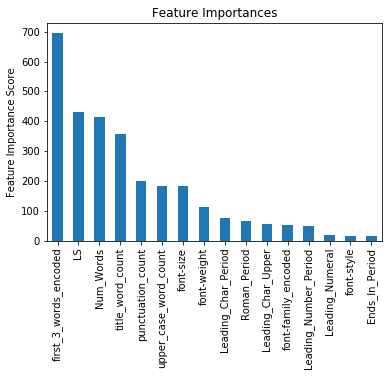

In [155]:
xgb3 = xgb.XGBClassifier(
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        objective='binary:logistic',
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=pos_wt,
        seed=seed)

xgboost_fit(xgb3, X_train_encoded, predictors)

In [156]:
y_pred = np.round(xgb3.predict(X_test_encoded))
y_pro = xgb3.predict_proba(X_test_encoded)[:, 1]
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.99
F1 score: 0.66
ROC AUC score: 0.89
True Negatives: 2258
False Negatives: 8
True Positives: 32
False Positives: 25
Precision: 0.56
Recall: 0.80


### Step 6: Reduce a learning rate and add more trees.

In [157]:
learning_rate = 0.01
n_estimators = 2000

The best value of n_estimators is 233.
Will use and set this value as the parameter, accordingly.


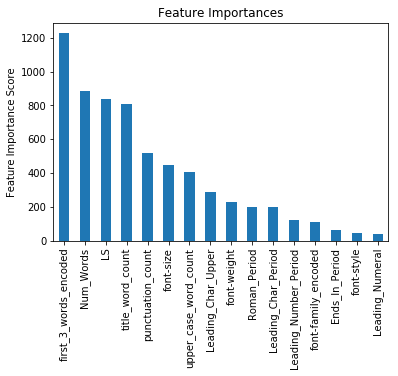

In [158]:
xgb4 = xgb.XGBClassifier(
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        objective='binary:logistic',
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=pos_wt,
        seed=seed)

xgboost_fit(xgb4, X_train_encoded, predictors)

In [159]:
y_pred = np.round(xgb4.predict(X_test_encoded))
y_pro = xgb4.predict_proba(X_test_encoded)[:, 1]
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.97
F1 score: 0.53
ROC AUC score: 0.91
True Negatives: 2229
False Negatives: 6
True Positives: 34
False Positives: 54
Precision: 0.39
Recall: 0.85


In [188]:
n_estimators=233

The best value of n_estimators is 233.
Will use and set this value as the parameter, accordingly.


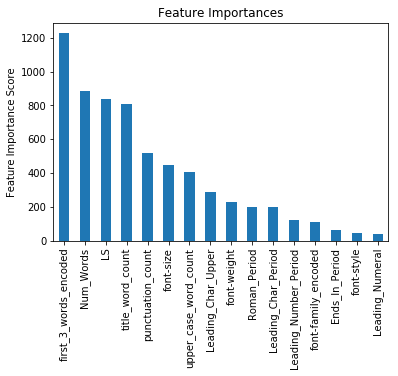

In [189]:
xgb5 = xgb.XGBClassifier(
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        objective='binary:logistic',
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=pos_wt,
        seed=seed)

xgboost_fit(xgb5, X_train_encoded, predictors)

In [190]:
y_pred = np.round(xgb5.predict(X_test_encoded))
y_pro = xgb5.predict_proba(X_test_encoded)[:, 1]
metrics(y_test, y_pred)
confusion_metrics(y_test, y_pred)

Score on a test set
Accuracy score: 0.97
F1 score: 0.53
ROC AUC score: 0.91
True Negatives: 2229
False Negatives: 6
True Positives: 34
False Positives: 54
Precision: 0.39
Recall: 0.85


#### Feature Importances

In [78]:
#X = X_test
X = X_test_encoded
y = y_test
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb1)
shap_values = explainer.shap_values(X_train_encoded)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [79]:
shap_values = shap.TreeExplainer(xgb1).shap_values(X_train_encoded)

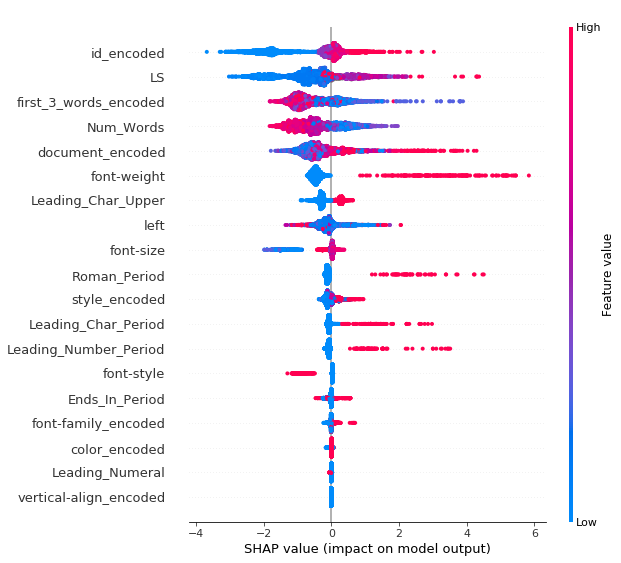

In [80]:
shap.summary_plot(shap_values, X_train_encoded)

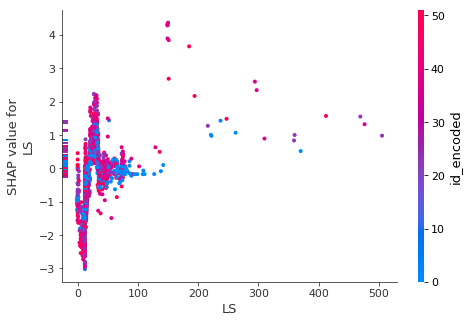

In [81]:
# we pass display_features so we get text display values for age
shap.dependence_plot("LS", shap_values, X_train_encoded)

In [82]:
def metrics(y_test, y_pred):
    print("Score on Train set")
    print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

In [83]:
y_test.shape, y_pred.shape

((3167,), (3167,))

In [84]:
metrics(y_test, y_pred)

Score on Train set
Accuracy score: 0.99
F1 score: 0.55
ROC AUC score: 0.69


In [85]:
def confusion_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])
    print("Precision: {:.2f}".format(cm[1][1]/float(cm[1][1]+cm[0][1])))
    print("Recall: {:.2f}".format(cm[1][1]/float(cm[1][1]+cm[1][0])))

In [86]:
confusion_metrics(y_test, y_pred)

True Negatives: 3099
False Negatives: 42
True Positives: 26
False Positives: 0
Precision: 1.00
Recall: 0.38


## Part III: Pipeline and Tune
* For this stage, we will use the best model

In [125]:
# 30% will be selected for testing data randomly
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.30,
                                                    shuffle = True,
                                                    random_state = 9834) 

### 1. Parameter Tuning on the Best Model with Pipeline

#### 1.1 Create the Preprocessing Pipeline

#### Categorical Features

In [126]:
cat_features = list(X.select_dtypes(include="object"))
cat_features.remove('First_Word')
cat_features.remove('Last_Word')
cat_features.remove('first_3_words')
cat_features.remove('first_5_words')
cat_features = cat_features

In [127]:
cat_features

['document', 'color', 'font-family']

#### Text Features

In [128]:
text_features = list(X.select_dtypes(include="object"))
text_features.remove('document')
text_features.remove('color')
text_features.remove('font-family')
text_features = text_features

In [129]:
text_features

['first_3_words', 'first_5_words', 'First_Word', 'Last_Word']

In [130]:
first_1 = [text_features[2], text_features[-1]]
first_3 = [text_features[0], text_features[-1]]
first_5 = [text_features[1], text_features[-1]]

In [131]:
X_train[first_1] = X_train[first_1].astype('U')
X_train[first_3] = X_train[first_1].astype('U')
X_train[first_5] = X_train[first_1].astype('U')

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


#### Numeric Features: We can just borrow from the separations I had made above

In [132]:
list(X.select_dtypes(exclude="object"))

['font-size',
 'font-weight',
 'font-style',
 'left',
 'top',
 'Num_Words',
 'Leading_Char_Upper',
 'Leading_Numeral',
 'Ends_In_Period',
 'Leading_Number_Period',
 'Leading_Char_Period',
 'Roman_Period',
 'LS']

In [133]:
binary_features = list(X_train_binary)

In [134]:
continuous_features = list(X_train_cont)

#### Chain up Transformations

In [ ]:
class ArrayCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        print(data.shape)
        print(np.transpose(np.matrix(data)).shape)
        return np.transpose(np.matrix(data))
    

In [135]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
                
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

text_transformer = Pipeline([('count_vect', CountVectorizer()), 
                             ('transformer', TfidfTransformer())])
# count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 2))
# tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

In [136]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, continuous_features),
        ('cat', categorical_transformer, cat_features),
        ('text', text_transformer, first_3)])

In [137]:
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(class_weight = 'balanced'))])

In [138]:
param_grid = {'classifier__n_estimators':[10,20,30,40,50,60,70],
               'classifier__max_depth':[5,10,20,30,40,50]}
cv = StratifiedKFold(n_splits=5)

In [139]:
grid_rf = GridSearchCV(final_pipeline, param_grid, cv=5, scoring = 'roc_auc')
grid_rf.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,2].shape[0] == 2, expected 4335.

In [ ]:
print("Best Score %s" % grid_rf.best_score_)
print("Best Parameter %s" % grid_rf.best_params_)

### 2. Change Thresholds and Re-evaluate Models

In [ ]:
pred_probs = grid_rf.predict_proba(X_train)[:, 1]

In [ ]:
plt.hist(pred_probs, bins=4)
plt.show()

In [ ]:
for i in np.arange(0,0.5,0.05):
    y_pred = grid_rf.predict_proba(X_train)[:, 1] > i
    print("")
    print("Metrics")
    print("")
    print(confusion_metrics(y_train, y_pred))

#### Feature Importances

In [ ]:
def plot_top_k_feature_importances_pipe(feature_names, coefs, k): 

    # sort 
    args = abs(coefs).argsort()[::-1][:k]    
    # get coefs 
    top_k_coefs = coefs[args]    
    # get column names
    colnames = feature_names[args]
    # plot 
    plt.barh(range(k), top_k_coefs, align='center') 
    plt.yticks(np.arange(k), colnames) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, k)
    plt.show()

In [ ]:
cat_cols = grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names()
num_cols = np.asarray(grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[0][2])
one_hot_feature_names_rf = np.concatenate((cat_cols, num_cols), axis = None)

In [ ]:
plot_top_k_feature_importances_pipe(one_hot_feature_names_rf, grid_rf.best_estimator_.named_steps['classifier'].feature_importances_, 20)

### 3. Evaluate on Test Set

In [ ]:
grid_rf.score(X_test,y_test)

In [ ]:
y_pred = grid_rf.predict(X_test)

#### Other Metrics

In [ ]:
metrics(y_test, y_pred)

In [ ]:
confusion_metrics(y_test, y_pred)

In [ ]:
classification_report(y_test, y_pred)

#### Thresholding

In [ ]:
pred_probs = grid_rf.predict_proba(X_test)[:, 1] 

In [ ]:
plt.hist(pred_probs, bins=5)
plt.show()

In [ ]:
for i in np.arange(0,0.5,0.01):
    y_pred = grid_rf.predict_proba(X_test)[:, 1] > i
    print("")
    print("Metrics")
    print("Threshold =", i)
    print("")
    print(metrics(y_test, y_pred))
    print(confusion_metrics(y_test, y_pred))

##### EXTRA: GridSearch With Wrapper with refit = recall score

In [ ]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
} 

In [ ]:
def grid_search_wrapper(refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(pipe_rf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')
grid_search_clf.fit(X_train, y_train)


In [ ]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score'
         ]].head(10)

In [ ]:
y_pred = grid_search_clf.best_estimator_.predict(X_train)
y_pred_class = grid_search_clf.best_estimator_.predict(X_test)

In [ ]:
print("Test Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred_class)))
print("Test F1 score: {:.2f}".format(f1_score(y_test, y_pred_class)))

In [ ]:
print("Train Accuracy score: {:.2f}".format(accuracy_score(y_train, y_pred)))
print("Train F1 score: {:.2f}".format(f1_score(y_train, y_pred)))

In [ ]:
print (classification_report(y_test, y_pred_class))